# IoT Intrusion Detection

The N-BaIoT Dataset contains traffic data for 9 IoT devices. The data comprise of both benign traffic and of a variety of malicious attacks. Here we run three deep neural networks to identify cyberattacks on a Provision PT-737E Security Camera.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!pip install -q kaggle

## Upload kaggle API json file (get it from kaggle)

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              222KB  2021-04-05 06:19:09           1779  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           1157  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            899  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19            404  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
!kaggle datasets download -d mkashifn/nbaiot-dataset

100% 1.75G/1.75G [00:41<00:00, 48.4MB/s]
100% 1.75G/1.75G [00:41<00:00, 45.6MB/s]


In [ ]:
!unzip /content/nbaiot-dataset.zip

Archive:  /content/nbaiot-dataset.zip
  inflating: 1.benign.csv            
  inflating: 1.gafgyt.combo.csv      
  inflating: 1.gafgyt.junk.csv       
  inflating: 1.gafgyt.scan.csv       
  inflating: 1.gafgyt.tcp.csv        
  inflating: 1.gafgyt.udp.csv        
  inflating: 1.mirai.ack.csv         
  inflating: 1.mirai.scan.csv        
  inflating: 1.mirai.syn.csv         
  inflating: 1.mirai.udp.csv         
  inflating: 1.mirai.udpplain.csv    
  inflating: 2.benign.csv            
  inflating: 2.gafgyt.combo.csv      
  inflating: 2.gafgyt.junk.csv       
  inflating: 2.gafgyt.scan.csv       
  inflating: 2.gafgyt.tcp.csv        
  inflating: 2.gafgyt.udp.csv        
  inflating: 2.mirai.ack.csv         
  inflating: 2.mirai.scan.csv        
  inflating: 2.mirai.syn.csv         
  inflating: 2.mirai.udp.csv         
  inflating: 2.mirai.udpplain.csv    
  inflating: 3.benign.csv            
  inflating: 3.gafgyt.combo.csv      
  inflating: 3.gafgyt.junk.csv       
  inflating:

## EDA Stage with Visualisation

Bilinear maps

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from scipy.stats import gaussian_kde
import scipy.stats as st

In [ ]:
# Bilinear maps
def normalize(X, x_min=0, x_max=1):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom

class BilinearMap:
    def __init__(self, target_n):
        self.target_cols = target_n

    def compute_coeff(self, X, y):
        try:
            Xt = np.transpose(X)
            Xp = np.dot(Xt, X)
            Xpi = np.linalg.inv(Xp)
            XpiXt = np.dot(Xpi, Xt)
            coeff = np.dot(XpiXt, y)
            print ('coeff.shape:', coeff.shape)
        except Exception as e:
            regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X, y)
            coeff = regressor.coef_
            print ('Exception:', e)

        return coeff

    def fit_transform(self, X, y):
        target_rows = X.shape[1]
        actual_rows = X.shape[0]
        required_rows = target_rows * self.target_cols

        if actual_rows < required_rows:
            assert False, f"{required_rows} rows are required, {actual_rows} are provided"

        Y = []
        for i in range(self.target_cols):
            start = i * target_rows
            end = start + target_rows
            coeff = self.compute_coeff(X[start:end,:], y[start:end])
            Y.extend(coeff.tolist())
            print("coeff.shape:", coeff.shape, "Len y:", len(Y), 'Start:', start, 'End:', end)
        Y = np.array(Y)
        Y = Y.reshape(target_rows, self.target_cols)
        print("Y.shape:", Y.shape)
        Z = np.dot(X, Y)
        return Z

In [ ]:
# Utility functions

def print_input_files():
    # Input data files are available in the "../input/" directory.
    for dirname, _, filenames in os.walk('/content/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# Dump text files
def dump_text_file(fname):
    with open(fname, 'r') as f:
        print(f.read())

# Dump CSV files
def dump_csv_file(fname, count=5):
    # count: 0 - column names only, -1 - all rows, default = 5 rows max
    df = pd.read_csv(fname)
    if count < 0:
        count = df.shape[0]
    return df.head(count)

# Dataset related functions
ds_nbaiot = '/content/'
dn_nbaiot = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

def fname(ds, f):
    if '.csv' not in f:
        f = f'{f}.csv'
    return os.path.join(ds, f)

def fname_nbaiot(f):
    return fname(ds_nbaiot, f)

def get_nbaiot_device_files():
    nbaiot_all_files = dump_csv_file(fname_nbaiot('data_summary'), -1)
    nbaiot_all_files = nbaiot_all_files.iloc[:,0:1].values
    device_id = 1
    indices = []
    for j in range(len(nbaiot_all_files)):
        if str(device_id) not in str(nbaiot_all_files[j]):
            indices.append(j)
            device_id += 1
    nbaiot_device_files = np.split(nbaiot_all_files, indices)
    return nbaiot_device_files

def get_nbaiot_device_data(device_id, count_norm=-1, count_anom=-1):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    if count_anom == -1:
        count_anom = count_norm
    device_index = device_id -1
    device_files = get_nbaiot_device_files()
    device_file = device_files[device_index]
    df = pd.DataFrame()
    y = []
    for i in range(len(device_file)):
        fname = str(device_file[i][0])
        df_c = pd.read_csv(fname_nbaiot(fname))
        count = count_anom
        if 'benign' in fname:
            count = count_norm
        rows = count if count >=0 else df_c.shape[0]
        print("processing", fname, "rows =", rows)
        y_np = np.ones(rows) if 'benign' in fname else np.zeros(rows)
        y.extend(y_np.tolist())
        df = pd.concat([df.iloc[:,:].reset_index(drop=True),
                      df_c.iloc[:rows,:].reset_index(drop=True)], axis=0)
    X = df.iloc[:,:].values
    y = np.array(y)
    return (X, y)

def get_nbaiot_devices_data():
    devices_data = []
    for i in range(9):
        device_id = i + 1
        (X, y) = get_nbaiot_device_data(device_id)
        devices_data.append((X, y))
    return devices_data

In [ ]:
# Visualization Functions

def plot_scatter_nbaiot_device(device_data, device_id, dim3=True):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    device_index = device_id-1
    print("scatter plot for", dn_nbaiot[device_index])
    (X, y) = device_data
    X_std = StandardScaler().fit_transform(X)

    bmap = PCA(n_components=2)
    X_bmap = bmap.fit_transform(X_std)

    print("X_bmap.shape:", X_bmap.shape, "X_std.shape:", X_std.shape)
    data_X = X_bmap[:,0]
    data_Y = X_bmap[:,1]
    data_Z = y
    data = np.column_stack((data_X, data_Y, data_Z))
    #if dim3:
    plot_3d_scatter(data, dn_nbaiot[device_index], 'PCA1', 'PCA2', 'Normal or Anomalous')
    #else:
    normal = mpatches.Patch(color='green', label='N')
    anomalous = mpatches.Patch(color='red', label='A')
    handles = [normal, anomalous]
    plot_2d_scatter(data, dn_nbaiot[device_index], 'PCA1', 'PCA2', handles)

def plot_surface_nbaiot_device(device_data, device_id):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    device_index = device_id-1
    print("scatter plot for", dn_nbaiot[device_index])
    (X, y) = device_data
    X_std = StandardScaler().fit_transform(X)

    bmap = PCA(n_components=2)
    X_bmap = bmap.fit_transform(X_std)

    print("X_bmap.shape:", X_bmap.shape, "X_std.shape:", X_std.shape)
    plot_3d_scatter_surface(X_bmap, dn_nbaiot[device_index], 'PCA1', 'PCA2', 'PCA3')

# Visualization related functions
def plot_3d_histogram(data):
    cols = data.shape[1]
    if cols < 2:
        assert False, 'The number of columns should be 2'
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X = data[:,0]
    Y = data[:,1]
    bins = 10
    hist, xedges, yedges = np.histogram2d(X, Y, bins=bins, range=[[0, bins*0.6], [0, bins*0.6]])

    # Construct arrays for the anchor positions of the bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()

    cmap = cm.get_cmap('cool')
    max_height = np.max(dz)
    min_height = np.min(dz)
    rgba = [cmap((k-min_height)/max_height) for k in dz] 
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=rgba)

    plt.show()

def plot_3d_surface(data, func):
    cols = data.shape[1]
    if cols < 2:
        assert False, 'The number of columns should be 2'
    X = data[:,0]
    Y = data[:,1]
    X, Y = np.meshgrid(X, Y)
    Z = func(X, Y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('surface');

def plot_3d_scatter(data, title=None, xlabel=None, ylabel=None, zlabel=None):
    cols = data.shape[1]
    if cols < 3:
        assert False, 'The number of columns should be 3'
    X = data[:,0]
    Y = data[:,1]
    Z = data[:,2]
    ax = plt.axes(projection='3d')
    ax.scatter(X, Y, Z, c = Z, cmap='RdYlGn')
    ax.set_title(title);
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.show()

def plot_3d_scatter_trisurf(data, title=None, xlabel=None, ylabel=None, zlabel=None):
    cols = data.shape[1]
    if cols < 3:
        assert False, 'The number of columns should be 3'
    X = data[:,0]
    Y = data[:,1]
    Z = data[:,2]

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title);
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    #ax.plot_surface(XX, YY, ZZ)
    surf = ax.plot_trisurf(X - X.mean(), Y - Y.mean(), Z - Z.mean(), cmap=cm.jet, linewidth=0.1)
    fig.colorbar(surf)
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(6))
    fig.tight_layout()
    plt.show()

def plot_3d_scatter_surface(data, title=None, xlabel=None, ylabel=None, zlabel=None):
    plot_3d_scatter_kde(data, title, xlabel, ylabel, zlabel)

def plot_3d_scatter_fxy(data, title=None, xlabel=None, ylabel=None, zlabel=None):
    cols = data.shape[1]
    if cols < 2:
        assert False, 'The number of columns should be 2'
    X = data[:,0]
    Y = data[:,1]
    XY = np.vstack([X,Y])
    Z = gaussian_kde(XY)(XY)

    # Sort the points by density, so that the densest points are plotted last
    idx = Z.argsort()
    x, y, z = X[idx], Y[idx], Z[idx]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    #surf = ax.plot_trisurf(x - x.mean(), y - y.mean(), z, cmap=cm.jet, linewidth=0.1)
    surf = ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.1)
    ax.scatter(x,y,z, marker='.', s=10, c="black", alpha=0.5)
    fig.colorbar(surf)
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(6))
    fig.tight_layout()


    ax.set_title(title);
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.show()

    return

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title);
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.plot_surface(XX, YY, ZZ)
    plt.show()

def plot_3d_scatter_kde(data, title=None, xlabel=None, ylabel=None, zlabel=None):
    cols = data.shape[1]
    if cols < 2:
        assert False, 'The number of columns should be 2'
    X = data[:,0]
    Y = data[:,1]

    Xmin = int(np.floor(np.amin(X)))
    Xmax = int(np.ceil(np.amax(X)))
    Ymin = int(np.floor(np.amin(Y)))
    Ymax = int(np.ceil(np.amax(Y)))

    xmin = min(Xmin, Ymin)
    ymin = min(Xmin, Ymin)
    xmax = max(Xmax, Ymax)
    ymax = max(Xmax, Ymax)

    # Peform the kernel density estimate
    xx, yy = np.mgrid[Xmin:Xmax:100j, Ymin:Ymax:100j]
    #xx, yy = np.meshgrid(X, Y)
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([X, Y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, f - f.mean(), rstride=1, cstride=1, cmap='jet', edgecolor='none')
    
    ## Or kernel density estimate plot instead of the contourf plot
    cset = ax.contour(xx, yy, f, colors='k')
    # Label plot
    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_title(title)
    plt.show()

def plot_2d_scatter(data, title=None, xlabel=None, ylabel=None, handles=None):
    cols = data.shape[1]
    if cols < 3:
        assert False, 'The number of columns should be 3'
    X = data[:,0]
    Y = data[:,1]
    Z = data[:,2]
    ax = plt.axes()
    scatter = ax.scatter(X, Y, c = ['green' if z > 0.5 else 'red' for z in Z], cmap='RdYlGn')
    ax.set_title(title);
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend(handles=handles)
    plt.show()

processing 1.benign.csv rows = 49548
processing 1.gafgyt.combo.csv rows = 59718
processing 1.gafgyt.junk.csv rows = 29068
processing 1.gafgyt.scan.csv rows = 29849
processing 1.gafgyt.tcp.csv rows = 92141
processing 1.gafgyt.udp.csv rows = 105874
processing 1.mirai.ack.csv rows = 102195
processing 1.mirai.scan.csv rows = 107685
processing 1.mirai.syn.csv rows = 122573
processing 1.mirai.udp.csv rows = 237665
processing 1.mirai.udpplain.csv rows = 81982
scatter plot for Danmini_Doorbell
X_bmap.shape: (1018298, 2) X_std.shape: (1018298, 115)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


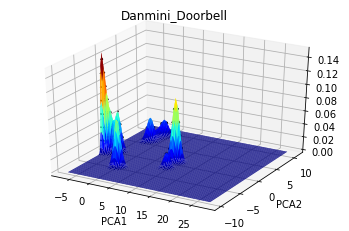

scatter plot for Danmini_Doorbell
X_bmap.shape: (1018298, 2) X_std.shape: (1018298, 115)


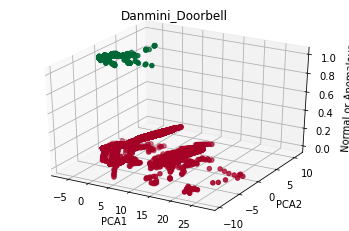

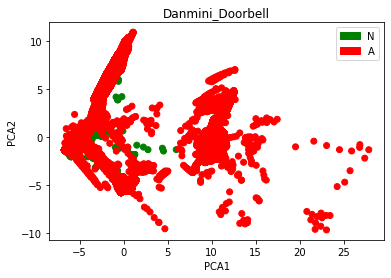

processing 2.benign.csv rows = 13113
processing 2.gafgyt.combo.csv rows = 53012
processing 2.gafgyt.junk.csv rows = 30312
processing 2.gafgyt.scan.csv rows = 27494
processing 2.gafgyt.tcp.csv rows = 95021
processing 2.gafgyt.udp.csv rows = 104791
processing 2.mirai.ack.csv rows = 113285
processing 2.mirai.scan.csv rows = 43192
processing 2.mirai.syn.csv rows = 116807
processing 2.mirai.udp.csv rows = 151481
processing 2.mirai.udpplain.csv rows = 87368
scatter plot for Ecobee_Thermostat
X_bmap.shape: (835876, 2) X_std.shape: (835876, 115)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


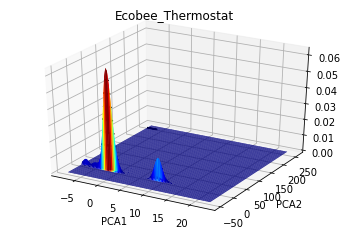

scatter plot for Ecobee_Thermostat
X_bmap.shape: (835876, 2) X_std.shape: (835876, 115)


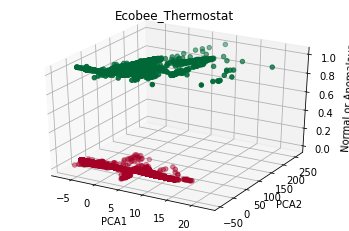

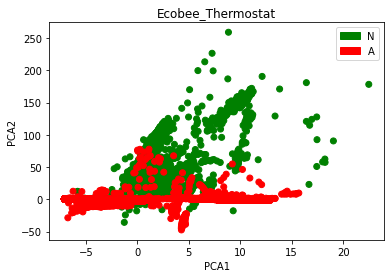

processing 3.benign.csv rows = 39100
processing 3.gafgyt.combo.csv rows = 53014
processing 3.gafgyt.junk.csv rows = 29797
processing 3.gafgyt.scan.csv rows = 28120
processing 3.gafgyt.tcp.csv rows = 101536
processing 3.gafgyt.udp.csv rows = 103933
scatter plot for Ennio_Doorbell
X_bmap.shape: (355500, 2) X_std.shape: (355500, 115)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


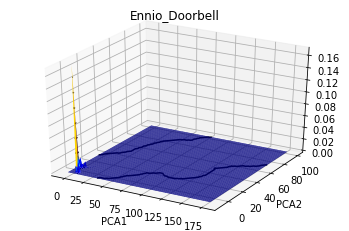

scatter plot for Ennio_Doorbell
X_bmap.shape: (355500, 2) X_std.shape: (355500, 115)


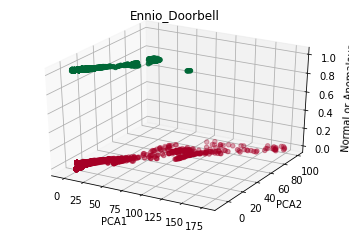

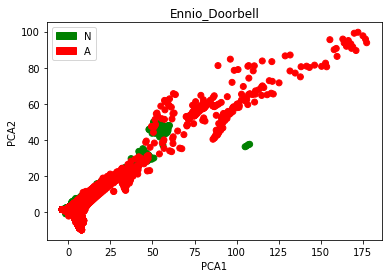

processing 4.benign.csv rows = 175240
processing 4.gafgyt.combo.csv rows = 58152
processing 4.gafgyt.junk.csv rows = 28349
processing 4.gafgyt.scan.csv rows = 27859
processing 4.gafgyt.tcp.csv rows = 92581
processing 4.gafgyt.udp.csv rows = 105782
processing 4.mirai.ack.csv rows = 91123
processing 4.mirai.scan.csv rows = 103621
processing 4.mirai.syn.csv rows = 118128
processing 4.mirai.udp.csv rows = 217034
processing 4.mirai.udpplain.csv rows = 80808
scatter plot for Philips_B120N10_Baby_Monitor
X_bmap.shape: (1098677, 2) X_std.shape: (1098677, 115)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


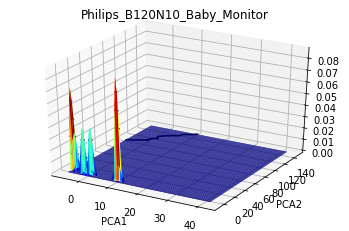

scatter plot for Philips_B120N10_Baby_Monitor
X_bmap.shape: (1098677, 2) X_std.shape: (1098677, 115)


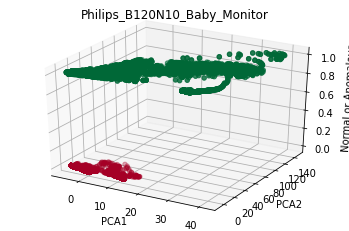

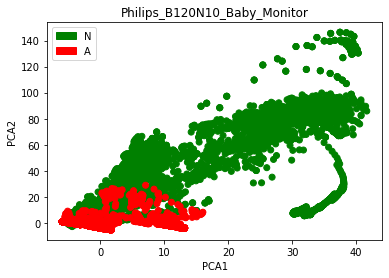

processing 5.benign.csv rows = 62154
processing 5.gafgyt.combo.csv rows = 61380
processing 5.gafgyt.junk.csv rows = 30898
processing 5.gafgyt.scan.csv rows = 29297
processing 5.gafgyt.tcp.csv rows = 104510
processing 5.gafgyt.udp.csv rows = 104011
processing 5.mirai.ack.csv rows = 60554
processing 5.mirai.scan.csv rows = 96781
processing 5.mirai.syn.csv rows = 65746
processing 5.mirai.udp.csv rows = 156248
processing 5.mirai.udpplain.csv rows = 56681
scatter plot for Provision_PT_737E_Security_Camera
X_bmap.shape: (828260, 2) X_std.shape: (828260, 115)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


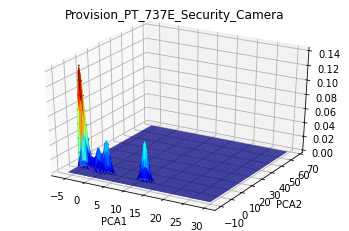

scatter plot for Provision_PT_737E_Security_Camera
X_bmap.shape: (828260, 2) X_std.shape: (828260, 115)


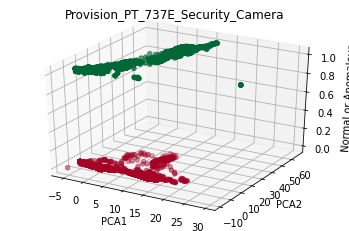

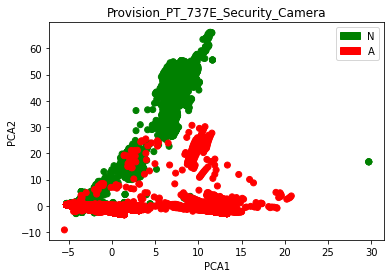

processing 6.benign.csv rows = 98514
processing 6.gafgyt.combo.csv rows = 57530
processing 6.gafgyt.junk.csv rows = 29068
processing 6.gafgyt.scan.csv rows = 28397
processing 6.gafgyt.tcp.csv rows = 89387
processing 6.gafgyt.udp.csv rows = 104658
processing 6.mirai.ack.csv rows = 57997
processing 6.mirai.scan.csv rows = 97096
processing 6.mirai.syn.csv rows = 61851
processing 6.mirai.udp.csv rows = 158608
processing 6.mirai.udpplain.csv rows = 53785
scatter plot for Provision_PT_838_Security_Camera
X_bmap.shape: (836891, 2) X_std.shape: (836891, 115)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


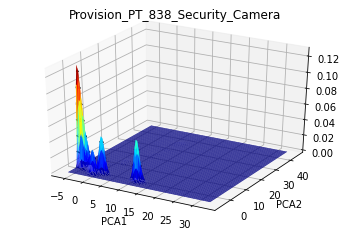

scatter plot for Provision_PT_838_Security_Camera
X_bmap.shape: (836891, 2) X_std.shape: (836891, 115)


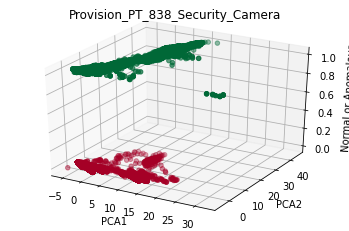

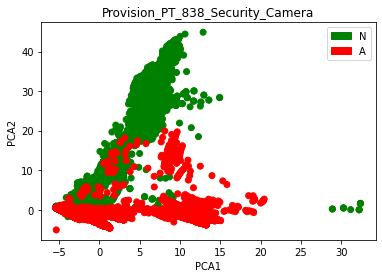

processing 7.benign.csv rows = 52150
processing 7.gafgyt.combo.csv rows = 58669
processing 7.gafgyt.junk.csv rows = 28305
processing 7.gafgyt.scan.csv rows = 27698
processing 7.gafgyt.tcp.csv rows = 97783
processing 7.gafgyt.udp.csv rows = 110617
scatter plot for Samsung_SNH_1011_N_Webcam
X_bmap.shape: (375222, 2) X_std.shape: (375222, 115)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


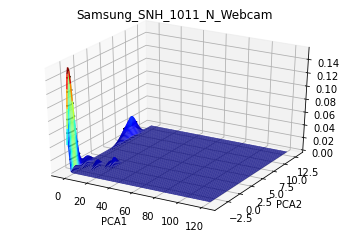

scatter plot for Samsung_SNH_1011_N_Webcam
X_bmap.shape: (375222, 2) X_std.shape: (375222, 115)


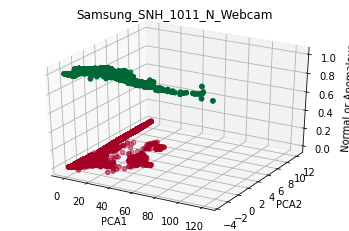

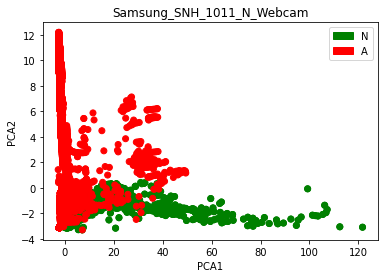

processing 8.benign.csv rows = 46585
processing 8.gafgyt.combo.csv rows = 54283
processing 8.gafgyt.junk.csv rows = 28579
processing 8.gafgyt.scan.csv rows = 27825
processing 8.gafgyt.tcp.csv rows = 88816
processing 8.gafgyt.udp.csv rows = 103720
processing 8.mirai.ack.csv rows = 111480
processing 8.mirai.scan.csv rows = 45930
processing 8.mirai.syn.csv rows = 125715
processing 8.mirai.udp.csv rows = 151879
processing 8.mirai.udpplain.csv rows = 78244
scatter plot for SimpleHome_XCS7_1002_WHT_Security_Camera
X_bmap.shape: (863056, 2) X_std.shape: (863056, 115)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


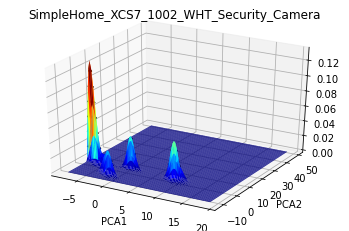

scatter plot for SimpleHome_XCS7_1002_WHT_Security_Camera
X_bmap.shape: (863056, 2) X_std.shape: (863056, 115)


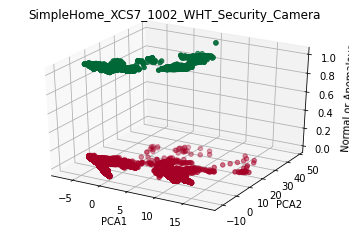

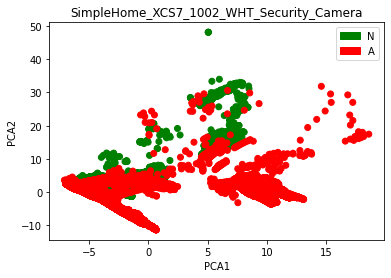

processing 9.benign.csv rows = 19528
processing 9.gafgyt.combo.csv rows = 59398
processing 9.gafgyt.junk.csv rows = 27413
processing 9.gafgyt.scan.csv rows = 28572
processing 9.gafgyt.tcp.csv rows = 98075
processing 9.gafgyt.udp.csv rows = 102980
processing 9.mirai.ack.csv rows = 107187
processing 9.mirai.scan.csv rows = 43674
processing 9.mirai.syn.csv rows = 122479
processing 9.mirai.udp.csv rows = 157084
processing 9.mirai.udpplain.csv rows = 84436
scatter plot for SimpleHome_XCS7_1003_WHT_Security_Camera
X_bmap.shape: (850826, 2) X_std.shape: (850826, 115)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


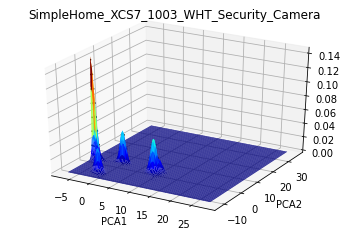

scatter plot for SimpleHome_XCS7_1003_WHT_Security_Camera
X_bmap.shape: (850826, 2) X_std.shape: (850826, 115)


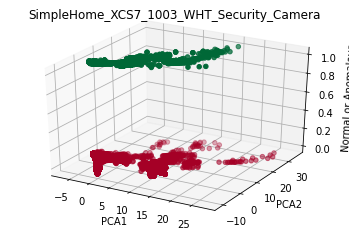

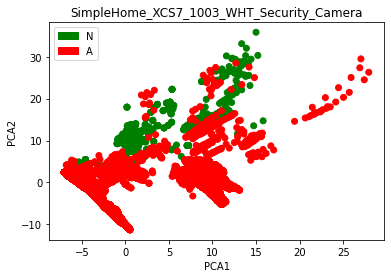

In [ ]:
import os

for i in range(9):
    device_index = i
    device_id = device_index + 1
    device_data = get_nbaiot_device_data(device_id)
    plot_surface_nbaiot_device(device_data, device_id)
    plot_scatter_nbaiot_device(device_data, device_id, False)

Feature Correlation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc, multilabel_confusion_matrix

from pylab import bone, pcolor, colorbar, plot, show, title

In [ ]:
def plot_correlation_matrix(df, title):
    graphWidth = 25
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {title}', fontsize=15)
    plt.show()

In [ ]:
def print_input_files():
    # Input data files are available in the "../input/" directory.
    for dirname, _, filenames in os.walk('/content/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# Dump text files
def dump_text_file(fname):
    with open(fname, 'r') as f:
        print(f.read())

# Dump CSV files
def dump_csv_file(fname, count=5):
    # count: 0 - column names only, -1 - all rows, default = 5 rows max
    df = pd.read_csv(fname)
    if count < 0:
        count = df.shape[0]
    return df.head(count)


# Dataset related functions
ds_nbaiot = '/content/nbaiot-dataset'
dn_nbaiot = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

def fname(ds, f):
    if '.csv' not in f:
        f = f'{f}.csv'
    return os.path.join(ds, f)

def fname_nbaiot(f):
    return fname('/content/', f)

def get_nbaiot_device_files():
    nbaiot_all_files = dump_csv_file(fname_nbaiot('data_summary'), -1)
    nbaiot_all_files = nbaiot_all_files.iloc[:,0:1].values
    device_id = 1
    indices = []
    for j in range(len(nbaiot_all_files)):
        if str(device_id) not in str(nbaiot_all_files[j]):
            indices.append(j)
            device_id += 1
    nbaiot_device_files = np.split(nbaiot_all_files, indices)
    return nbaiot_device_files

def get_nbaiot_device_data(device_id, count_norm=-1, count_anom=-1):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    if count_anom == -1:
        count_anom = count_norm
    device_index = device_id -1
    device_files = get_nbaiot_device_files()
    device_file = device_files[device_index]
    df = pd.DataFrame()
    y = []
    for i in range(len(device_file)):
        fname = str(device_file[i][0])
        df_c = pd.read_csv(fname_nbaiot(fname))
        count = count_anom
        if 'benign' in fname:
            count = count_norm
        rows = count if count >=0 else df_c.shape[0]
        print("processing", fname, "rows =", rows)
        y_np = np.ones(rows) if 'benign' in fname else np.zeros(rows)
        y.extend(y_np.tolist())
        df = pd.concat([df.iloc[:,:].reset_index(drop=True),
                      df_c.iloc[:rows,:].reset_index(drop=True)], axis=0)
    X = df.iloc[:,:].values
    y = np.array(y)
    Xdf = df
    return (X, y, Xdf)

def get_nbaiot_devices_data():
    devices_data = []
    for i in range(9):
        device_id = i + 1
        (X, y) = get_nbaiot_device_data(device_id)
        devices_data.append((X, y))
    return devices_data

processing 1.benign.csv rows = 49548
processing 1.gafgyt.combo.csv rows = 59718
processing 1.gafgyt.junk.csv rows = 29068
processing 1.gafgyt.scan.csv rows = 29849
processing 1.gafgyt.tcp.csv rows = 92141
processing 1.gafgyt.udp.csv rows = 105874
processing 1.mirai.ack.csv rows = 102195
processing 1.mirai.scan.csv rows = 107685
processing 1.mirai.syn.csv rows = 122573
processing 1.mirai.udp.csv rows = 237665
processing 1.mirai.udpplain.csv rows = 81982
There are 1018298 rows and 115 columns


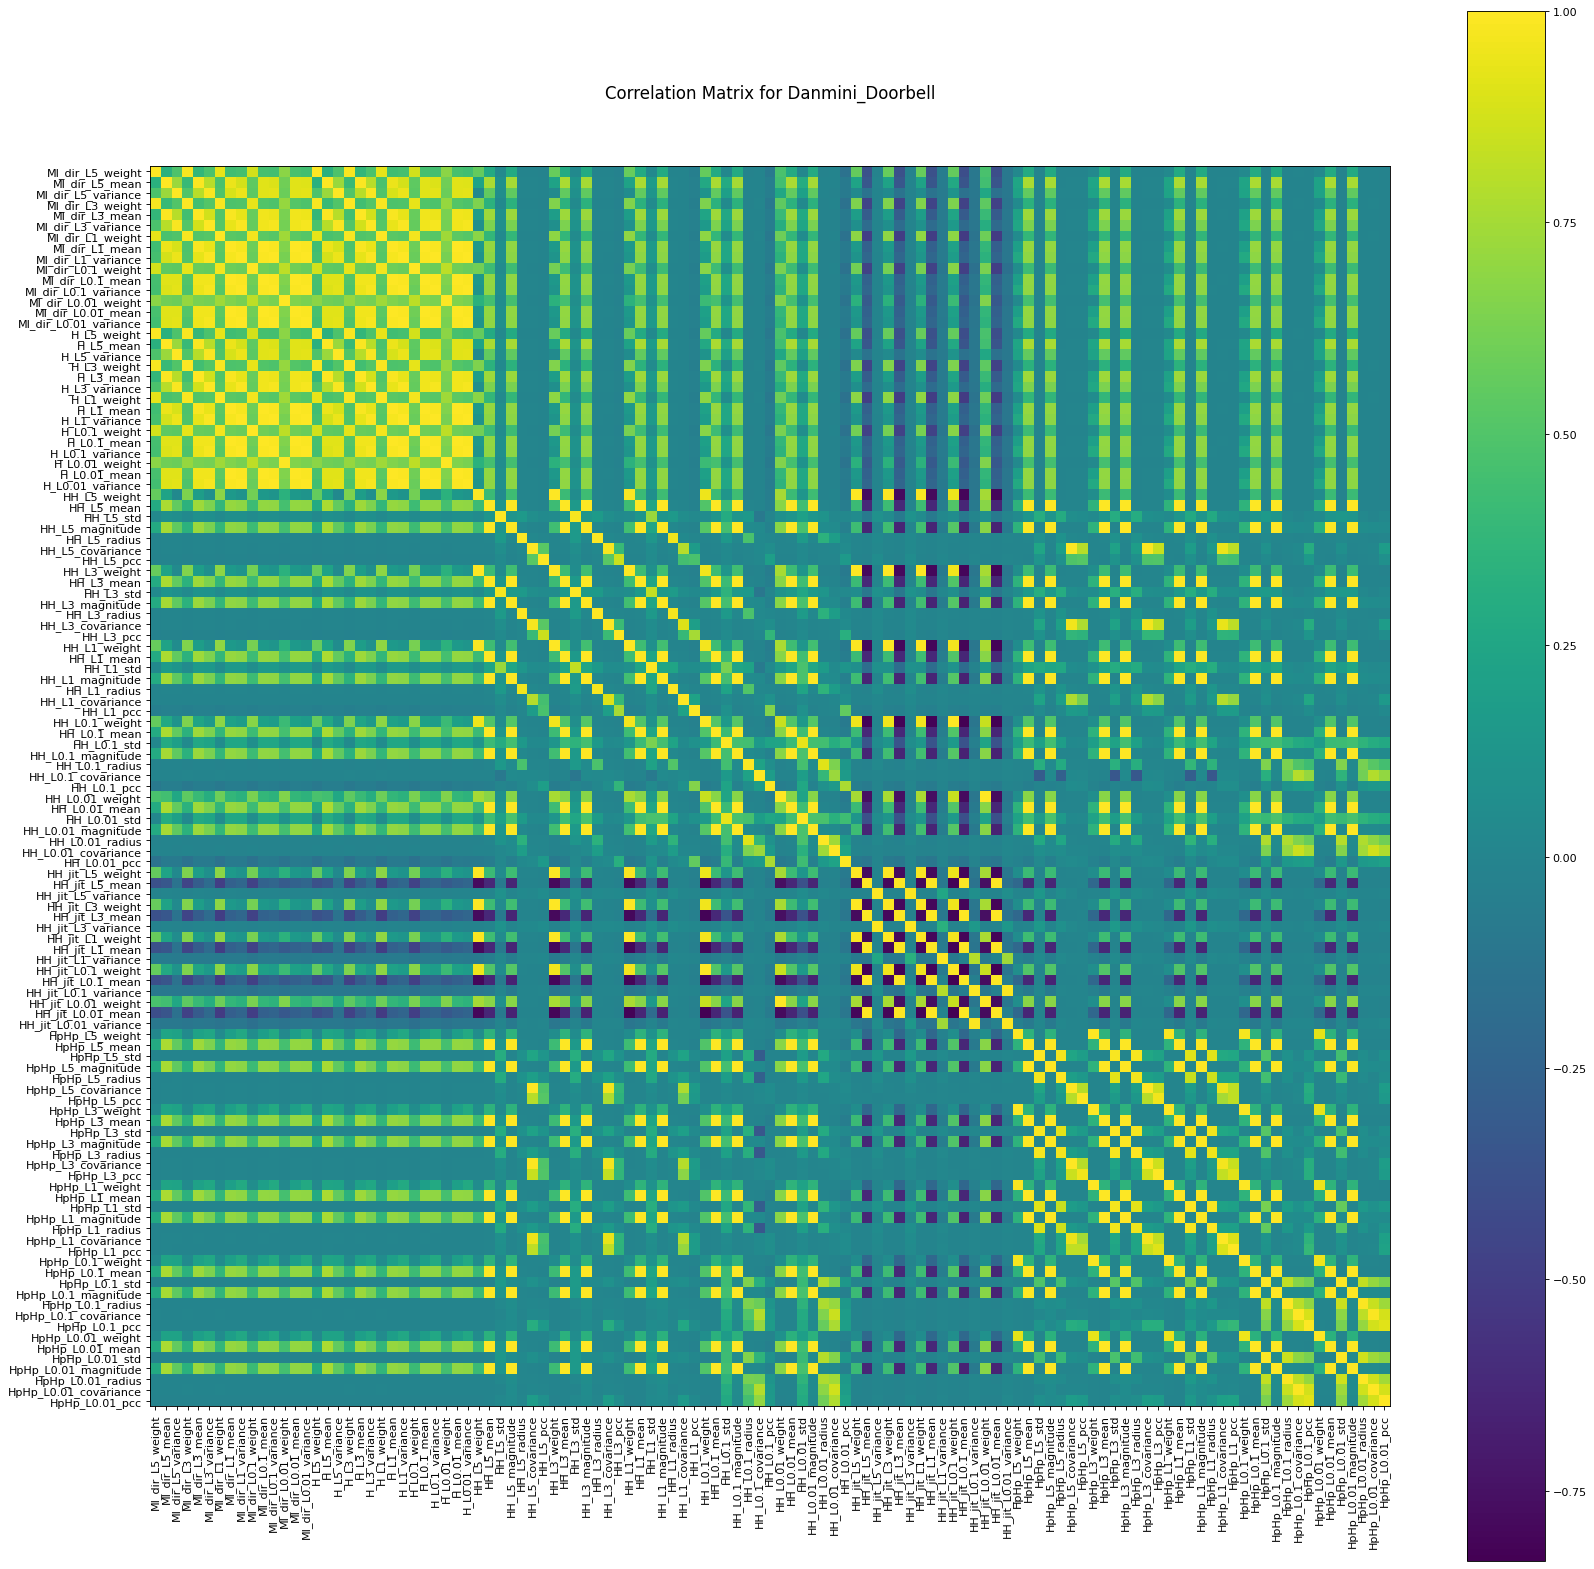

processing 2.benign.csv rows = 13113
processing 2.gafgyt.combo.csv rows = 53012
processing 2.gafgyt.junk.csv rows = 30312
processing 2.gafgyt.scan.csv rows = 27494
processing 2.gafgyt.tcp.csv rows = 95021
processing 2.gafgyt.udp.csv rows = 104791
processing 2.mirai.ack.csv rows = 113285
processing 2.mirai.scan.csv rows = 43192
processing 2.mirai.syn.csv rows = 116807
processing 2.mirai.udp.csv rows = 151481
processing 2.mirai.udpplain.csv rows = 87368
There are 835876 rows and 115 columns


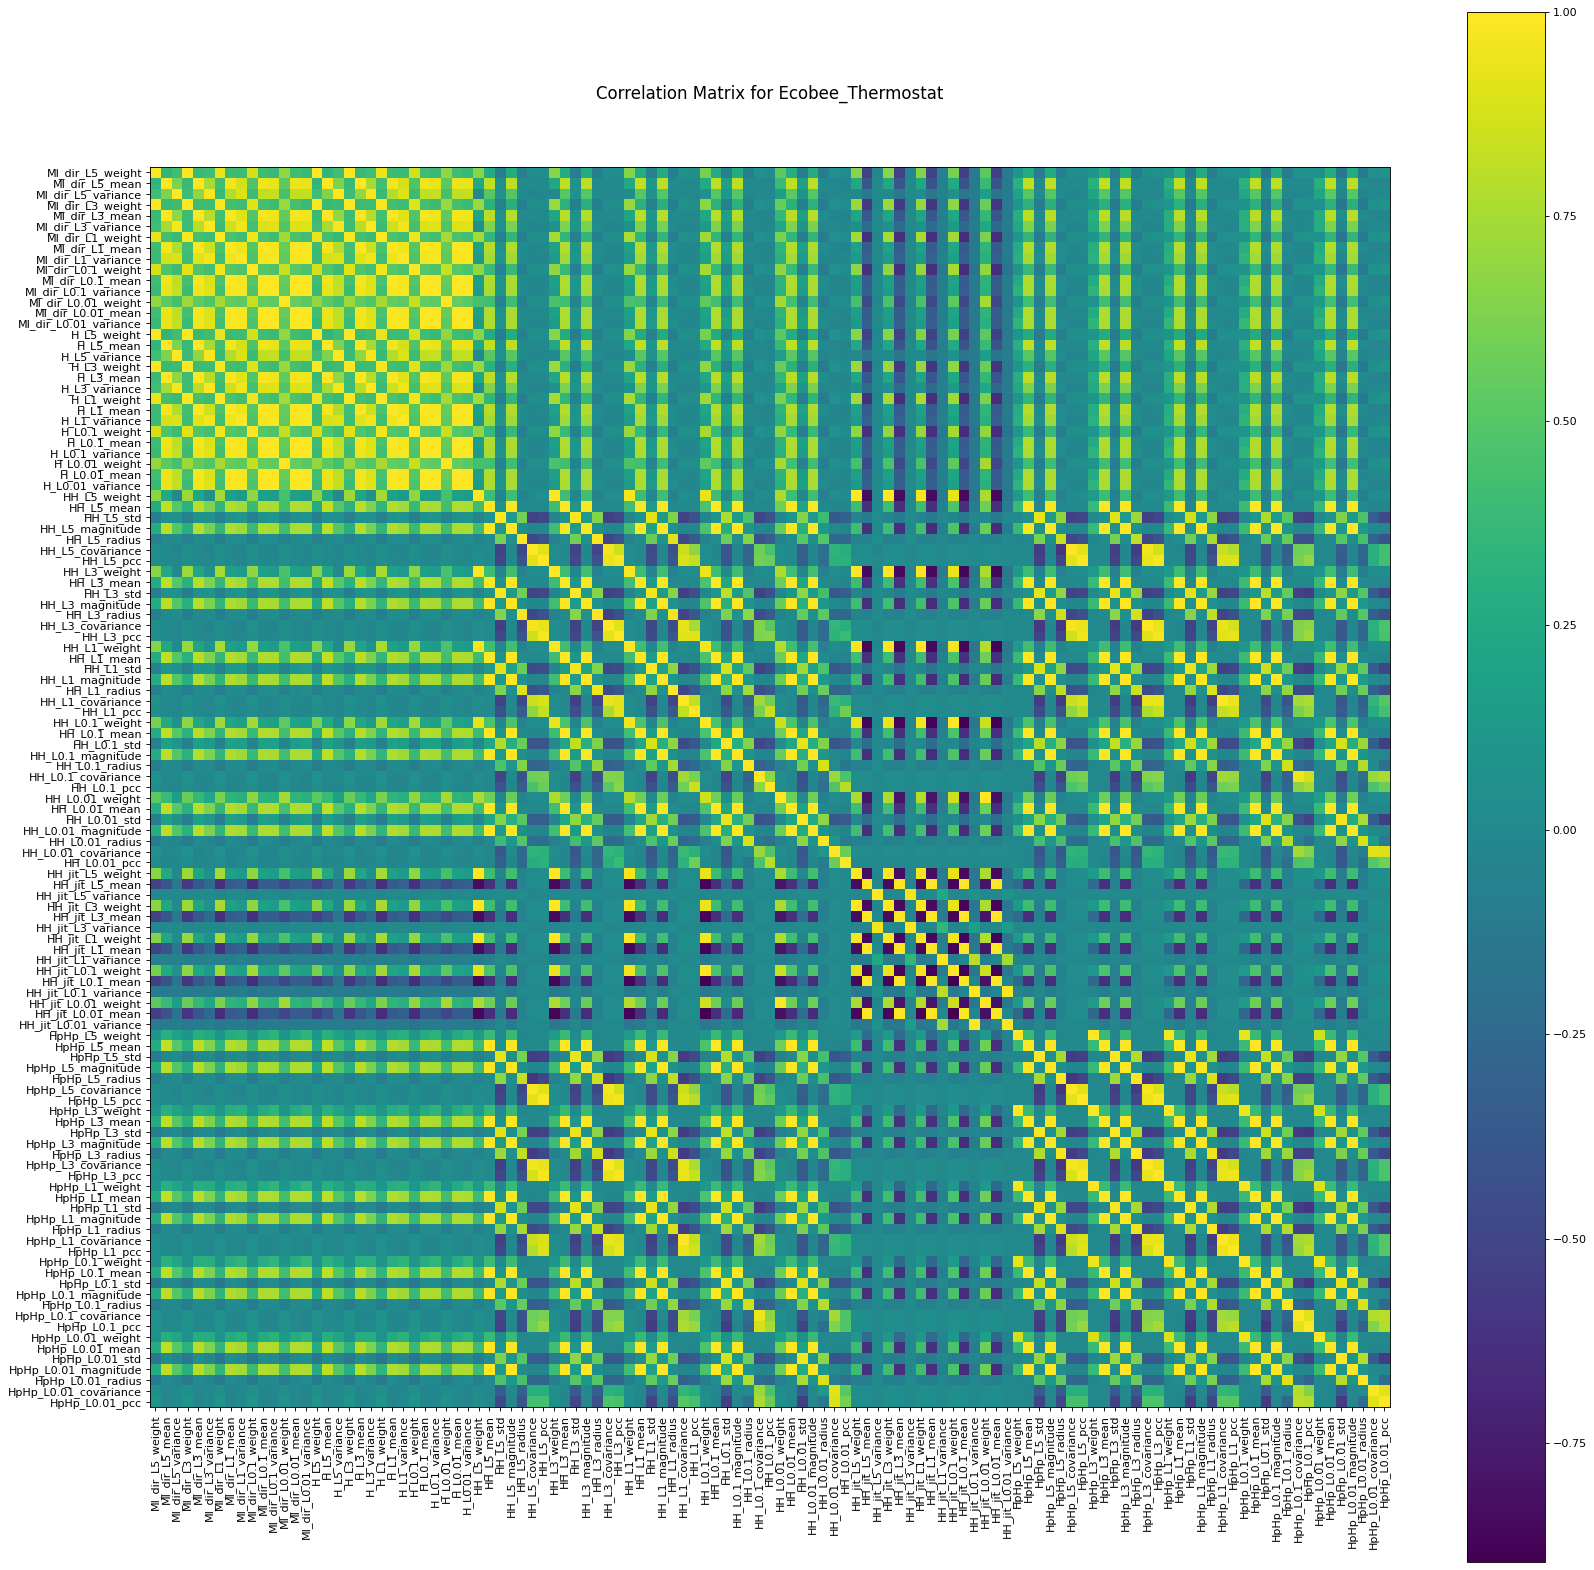

processing 3.benign.csv rows = 39100
processing 3.gafgyt.combo.csv rows = 53014
processing 3.gafgyt.junk.csv rows = 29797
processing 3.gafgyt.scan.csv rows = 28120
processing 3.gafgyt.tcp.csv rows = 101536
processing 3.gafgyt.udp.csv rows = 103933
There are 355500 rows and 115 columns


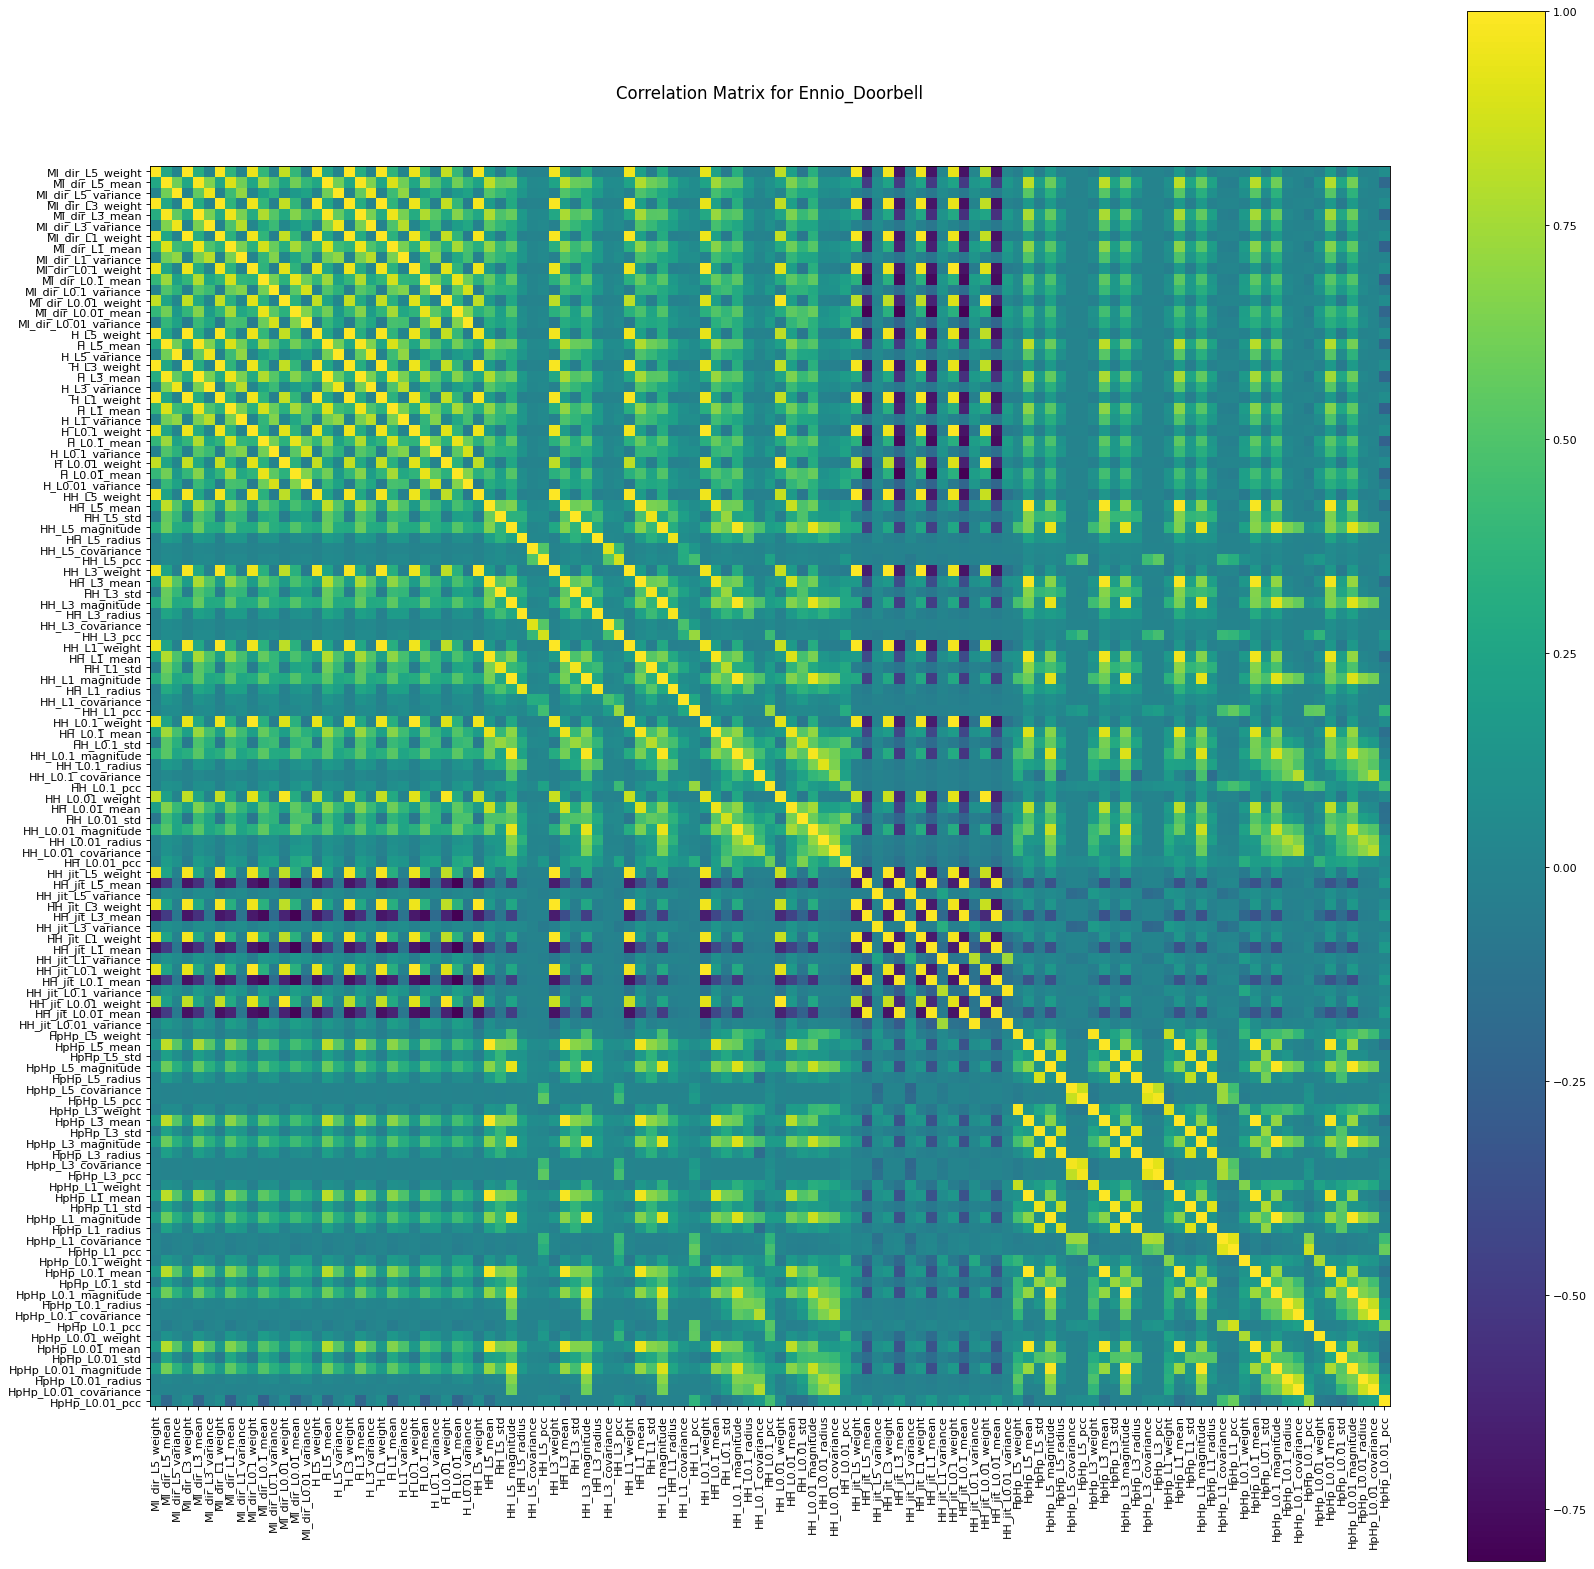

processing 4.benign.csv rows = 175240
processing 4.gafgyt.combo.csv rows = 58152
processing 4.gafgyt.junk.csv rows = 28349
processing 4.gafgyt.scan.csv rows = 27859
processing 4.gafgyt.tcp.csv rows = 92581
processing 4.gafgyt.udp.csv rows = 105782
processing 4.mirai.ack.csv rows = 91123
processing 4.mirai.scan.csv rows = 103621
processing 4.mirai.syn.csv rows = 118128
processing 4.mirai.udp.csv rows = 217034
processing 4.mirai.udpplain.csv rows = 80808
There are 1098677 rows and 115 columns


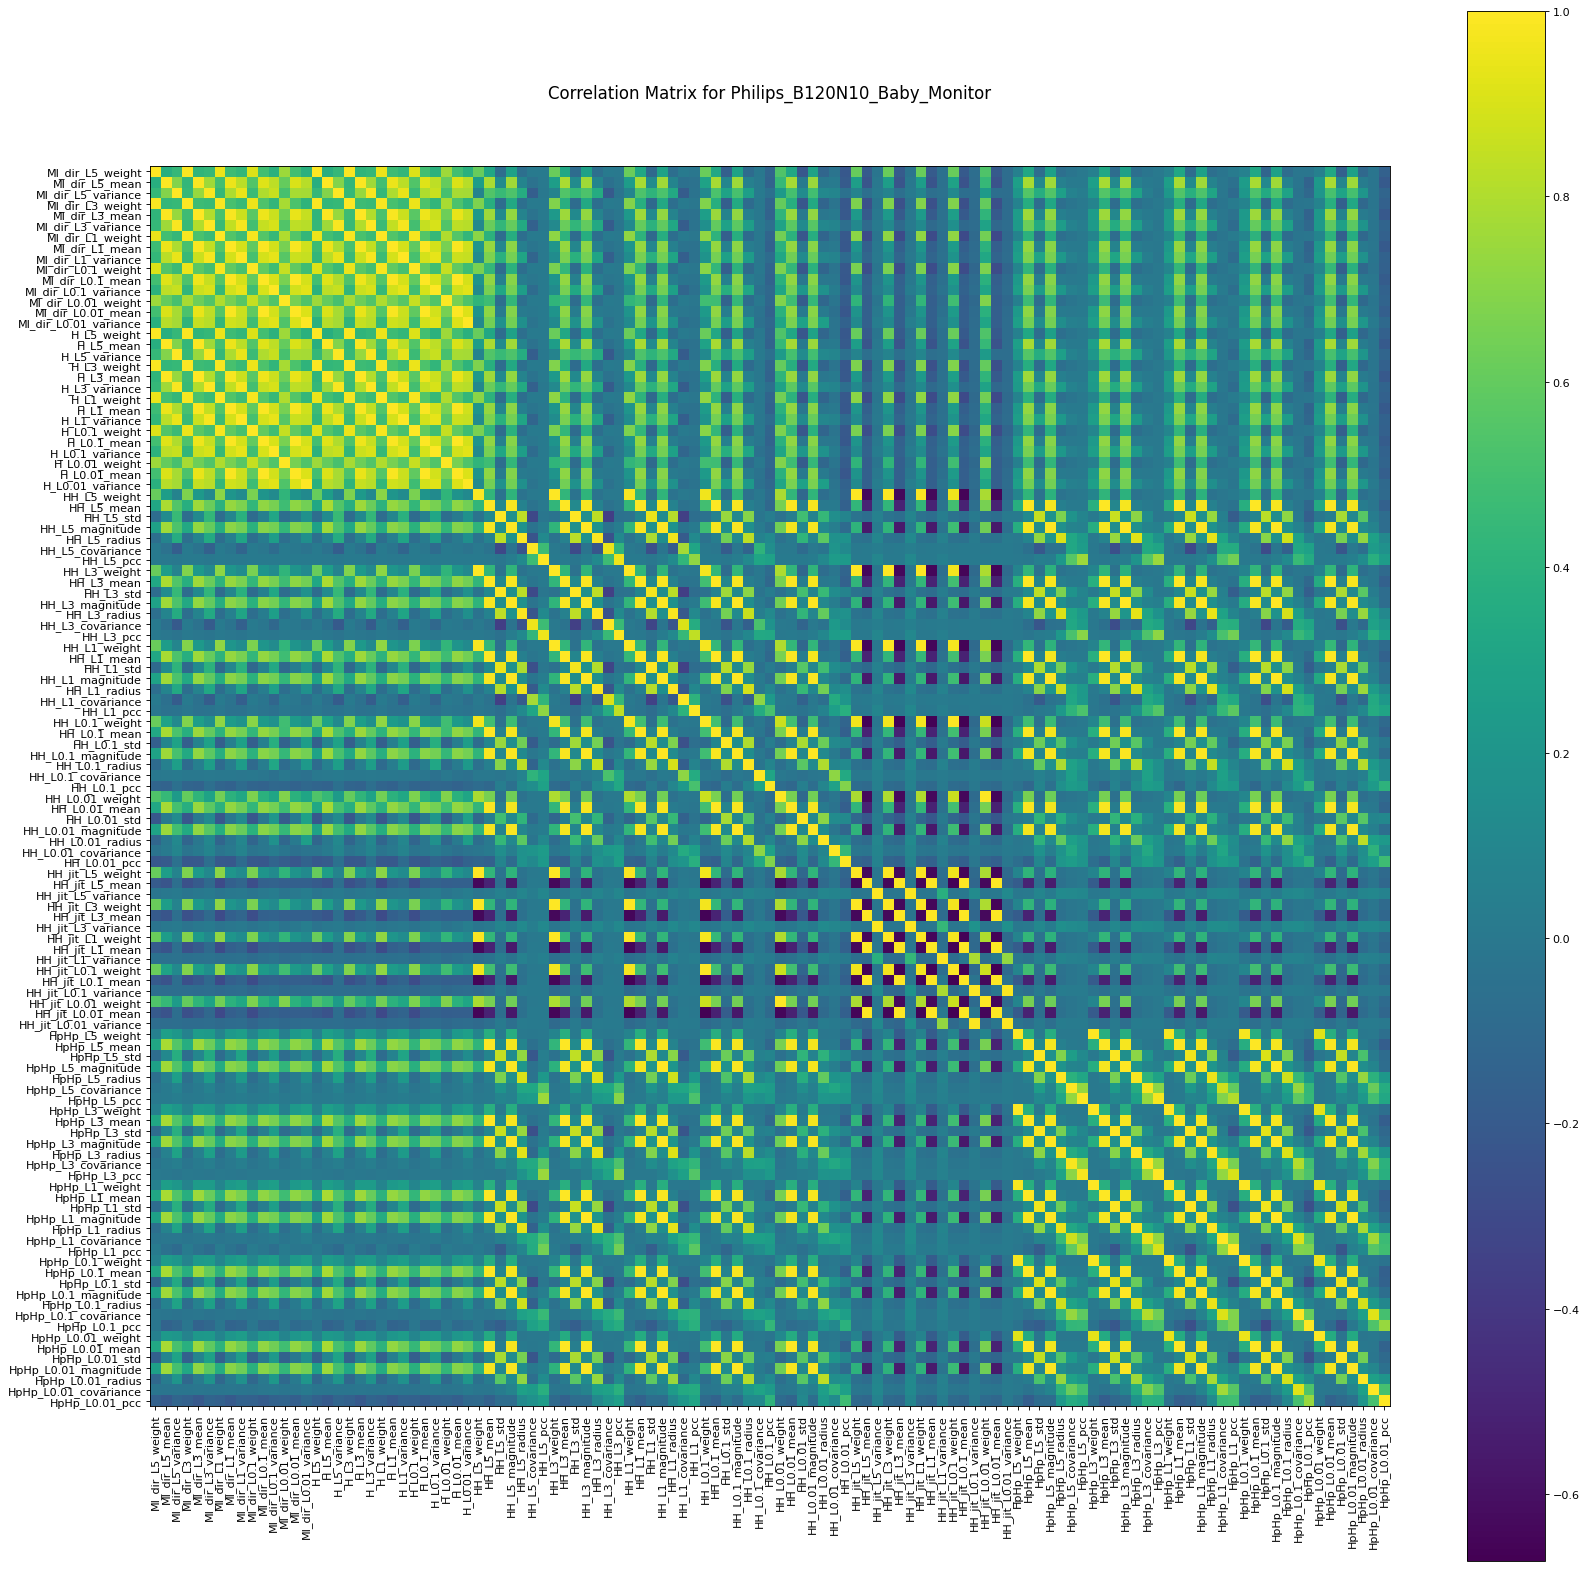

processing 5.benign.csv rows = 62154
processing 5.gafgyt.combo.csv rows = 61380
processing 5.gafgyt.junk.csv rows = 30898
processing 5.gafgyt.scan.csv rows = 29297
processing 5.gafgyt.tcp.csv rows = 104510
processing 5.gafgyt.udp.csv rows = 104011
processing 5.mirai.ack.csv rows = 60554
processing 5.mirai.scan.csv rows = 96781
processing 5.mirai.syn.csv rows = 65746
processing 5.mirai.udp.csv rows = 156248
processing 5.mirai.udpplain.csv rows = 56681
There are 828260 rows and 115 columns


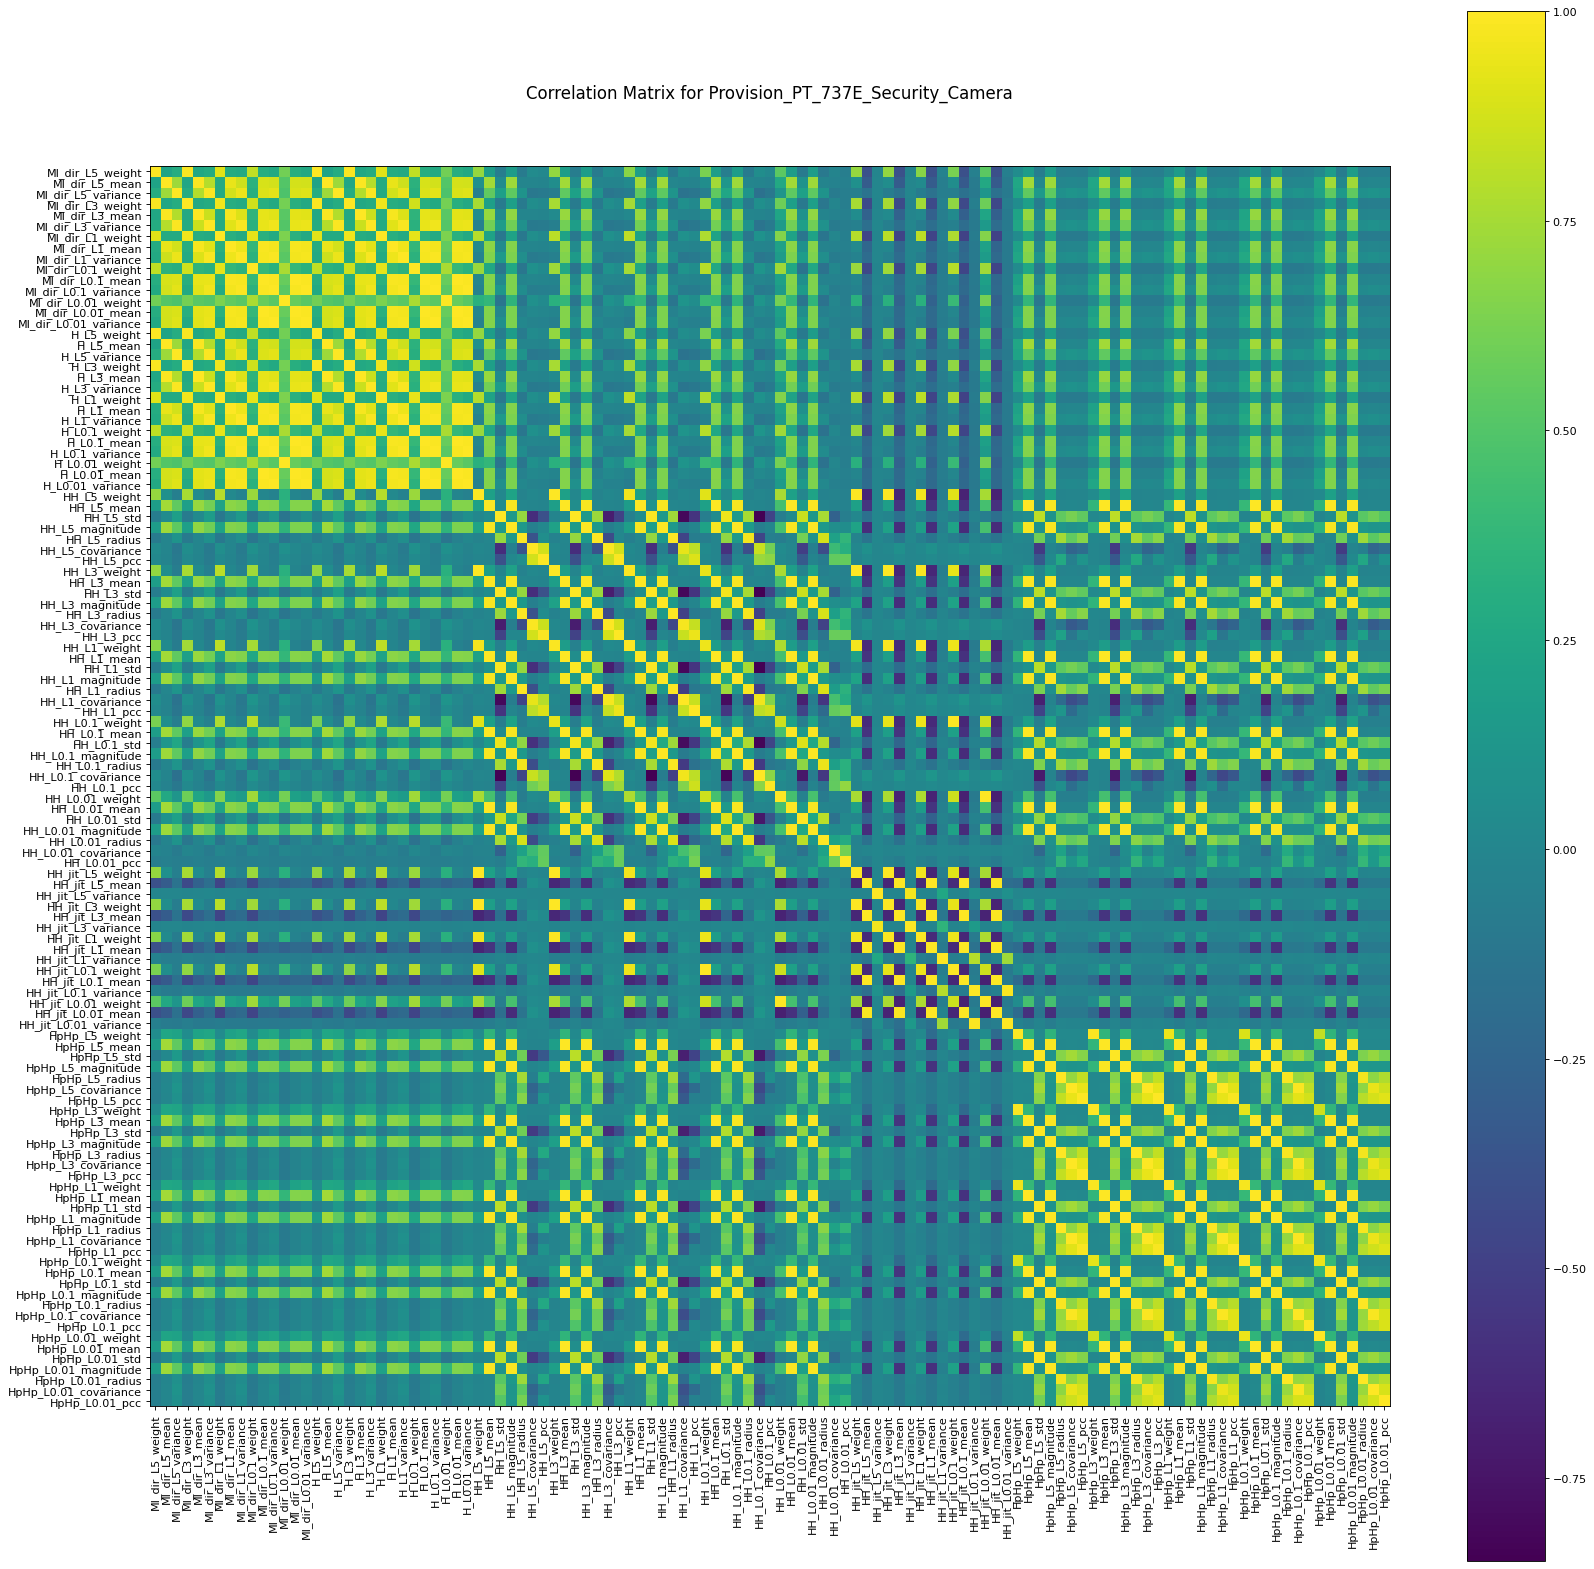

processing 6.benign.csv rows = 98514
processing 6.gafgyt.combo.csv rows = 57530
processing 6.gafgyt.junk.csv rows = 29068
processing 6.gafgyt.scan.csv rows = 28397
processing 6.gafgyt.tcp.csv rows = 89387
processing 6.gafgyt.udp.csv rows = 104658
processing 6.mirai.ack.csv rows = 57997
processing 6.mirai.scan.csv rows = 97096
processing 6.mirai.syn.csv rows = 61851
processing 6.mirai.udp.csv rows = 158608
processing 6.mirai.udpplain.csv rows = 53785
There are 836891 rows and 115 columns


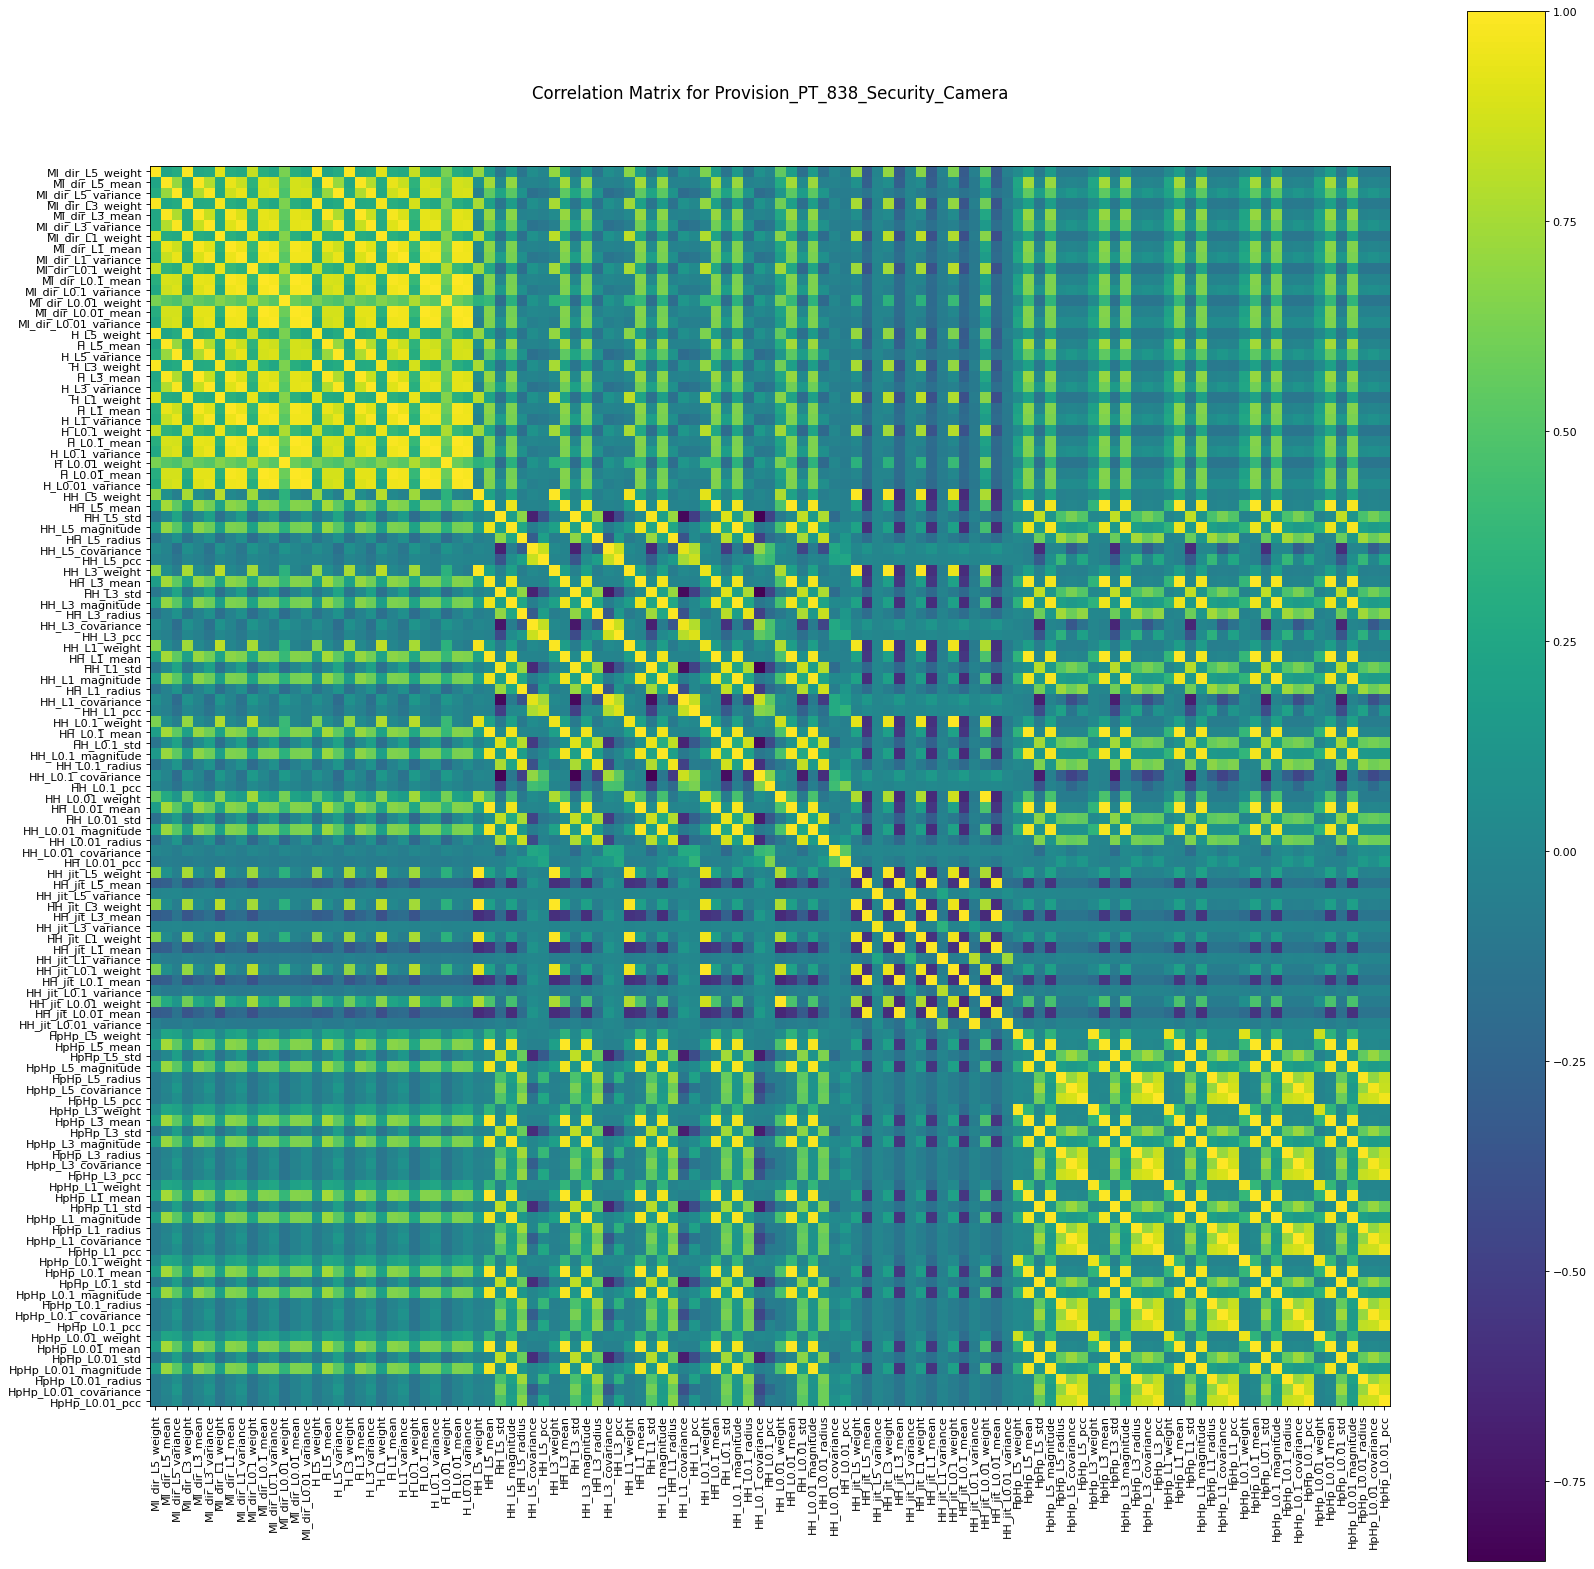

processing 7.benign.csv rows = 52150
processing 7.gafgyt.combo.csv rows = 58669
processing 7.gafgyt.junk.csv rows = 28305
processing 7.gafgyt.scan.csv rows = 27698
processing 7.gafgyt.tcp.csv rows = 97783
processing 7.gafgyt.udp.csv rows = 110617
There are 375222 rows and 115 columns


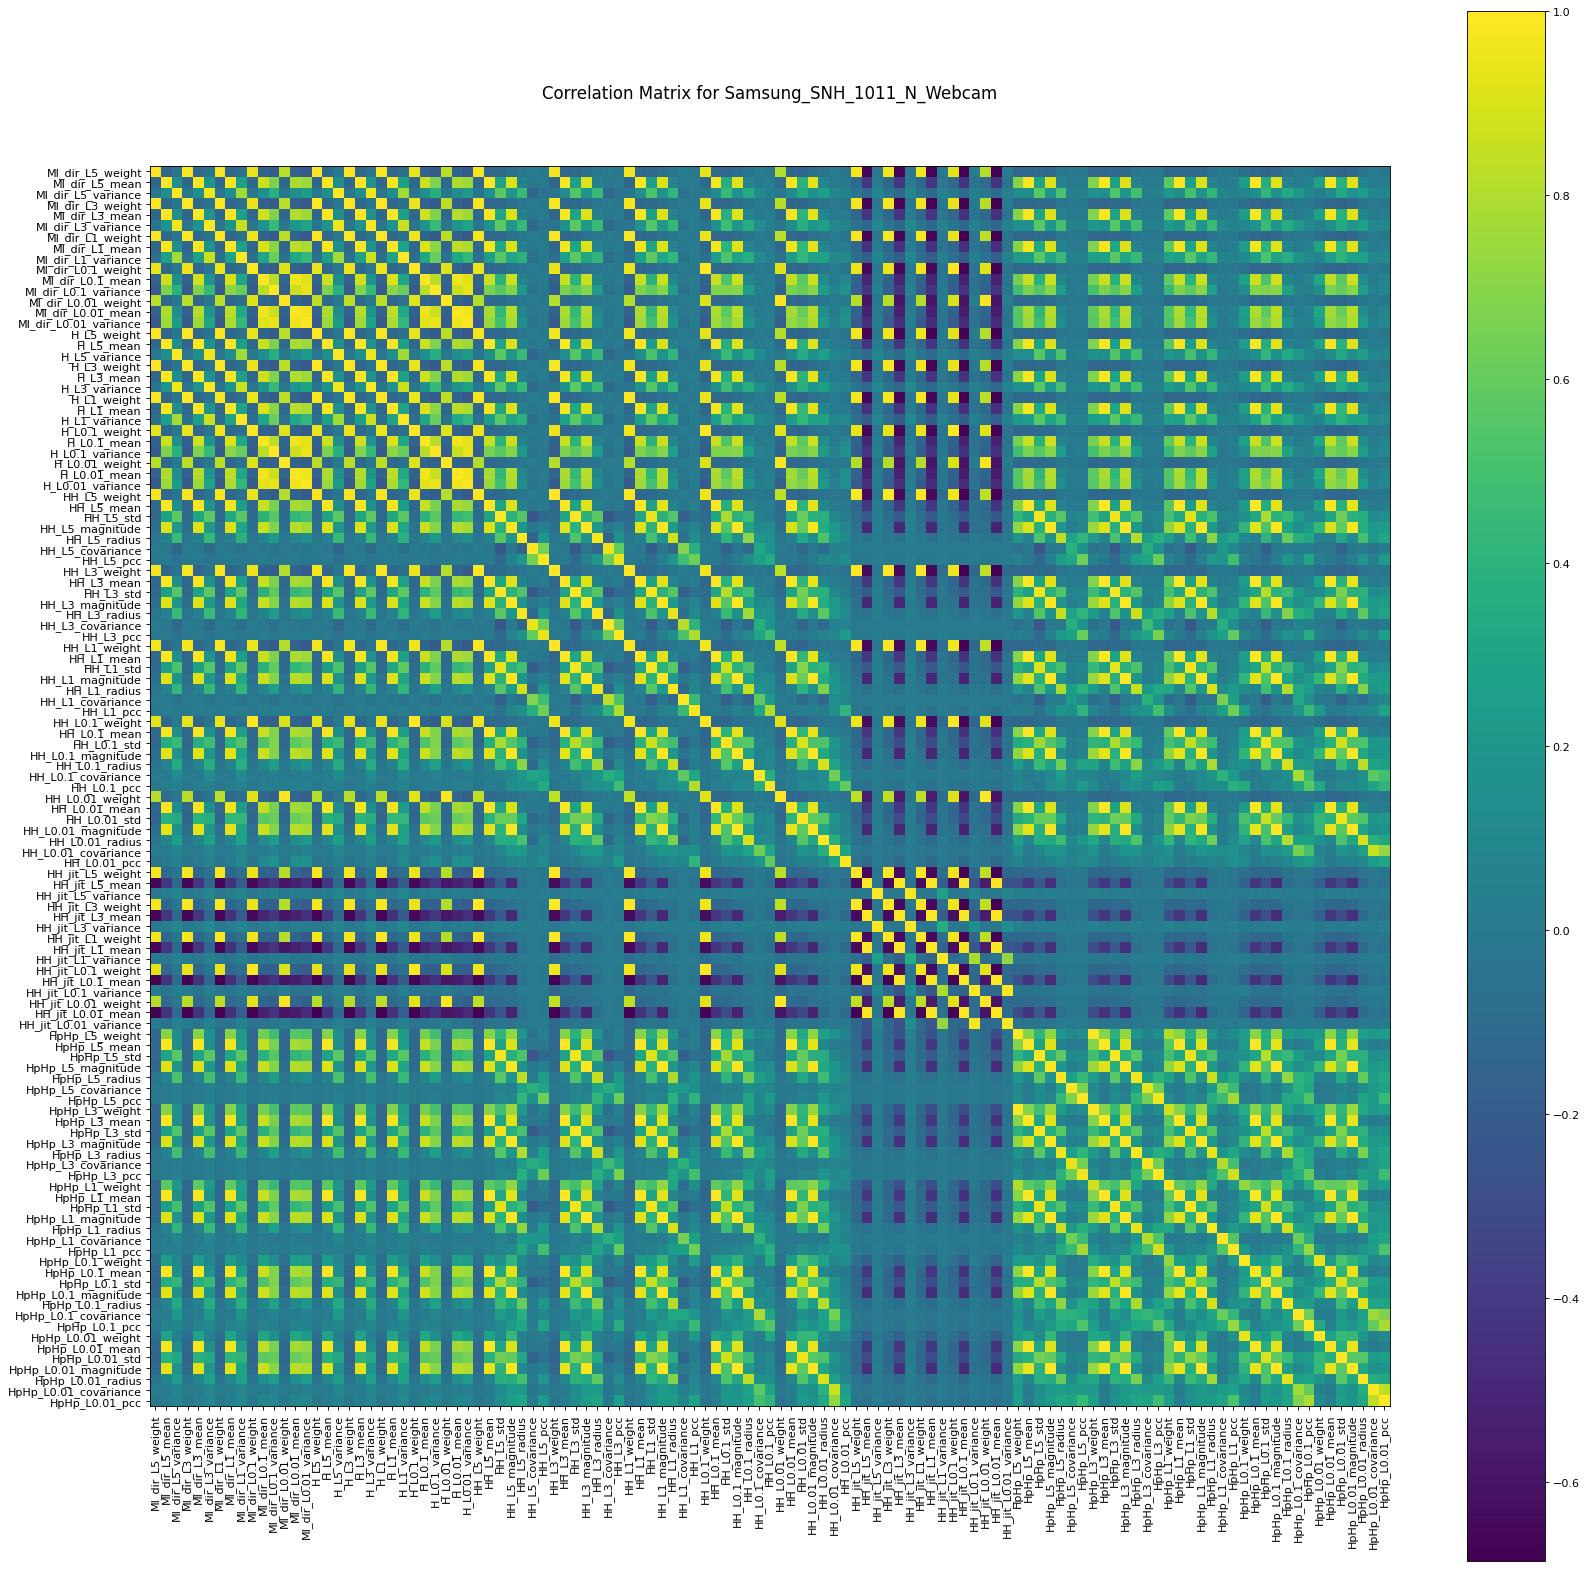

processing 8.benign.csv rows = 46585
processing 8.gafgyt.combo.csv rows = 54283
processing 8.gafgyt.junk.csv rows = 28579
processing 8.gafgyt.scan.csv rows = 27825
processing 8.gafgyt.tcp.csv rows = 88816
processing 8.gafgyt.udp.csv rows = 103720
processing 8.mirai.ack.csv rows = 111480
processing 8.mirai.scan.csv rows = 45930
processing 8.mirai.syn.csv rows = 125715
processing 8.mirai.udp.csv rows = 151879
processing 8.mirai.udpplain.csv rows = 78244
There are 863056 rows and 115 columns


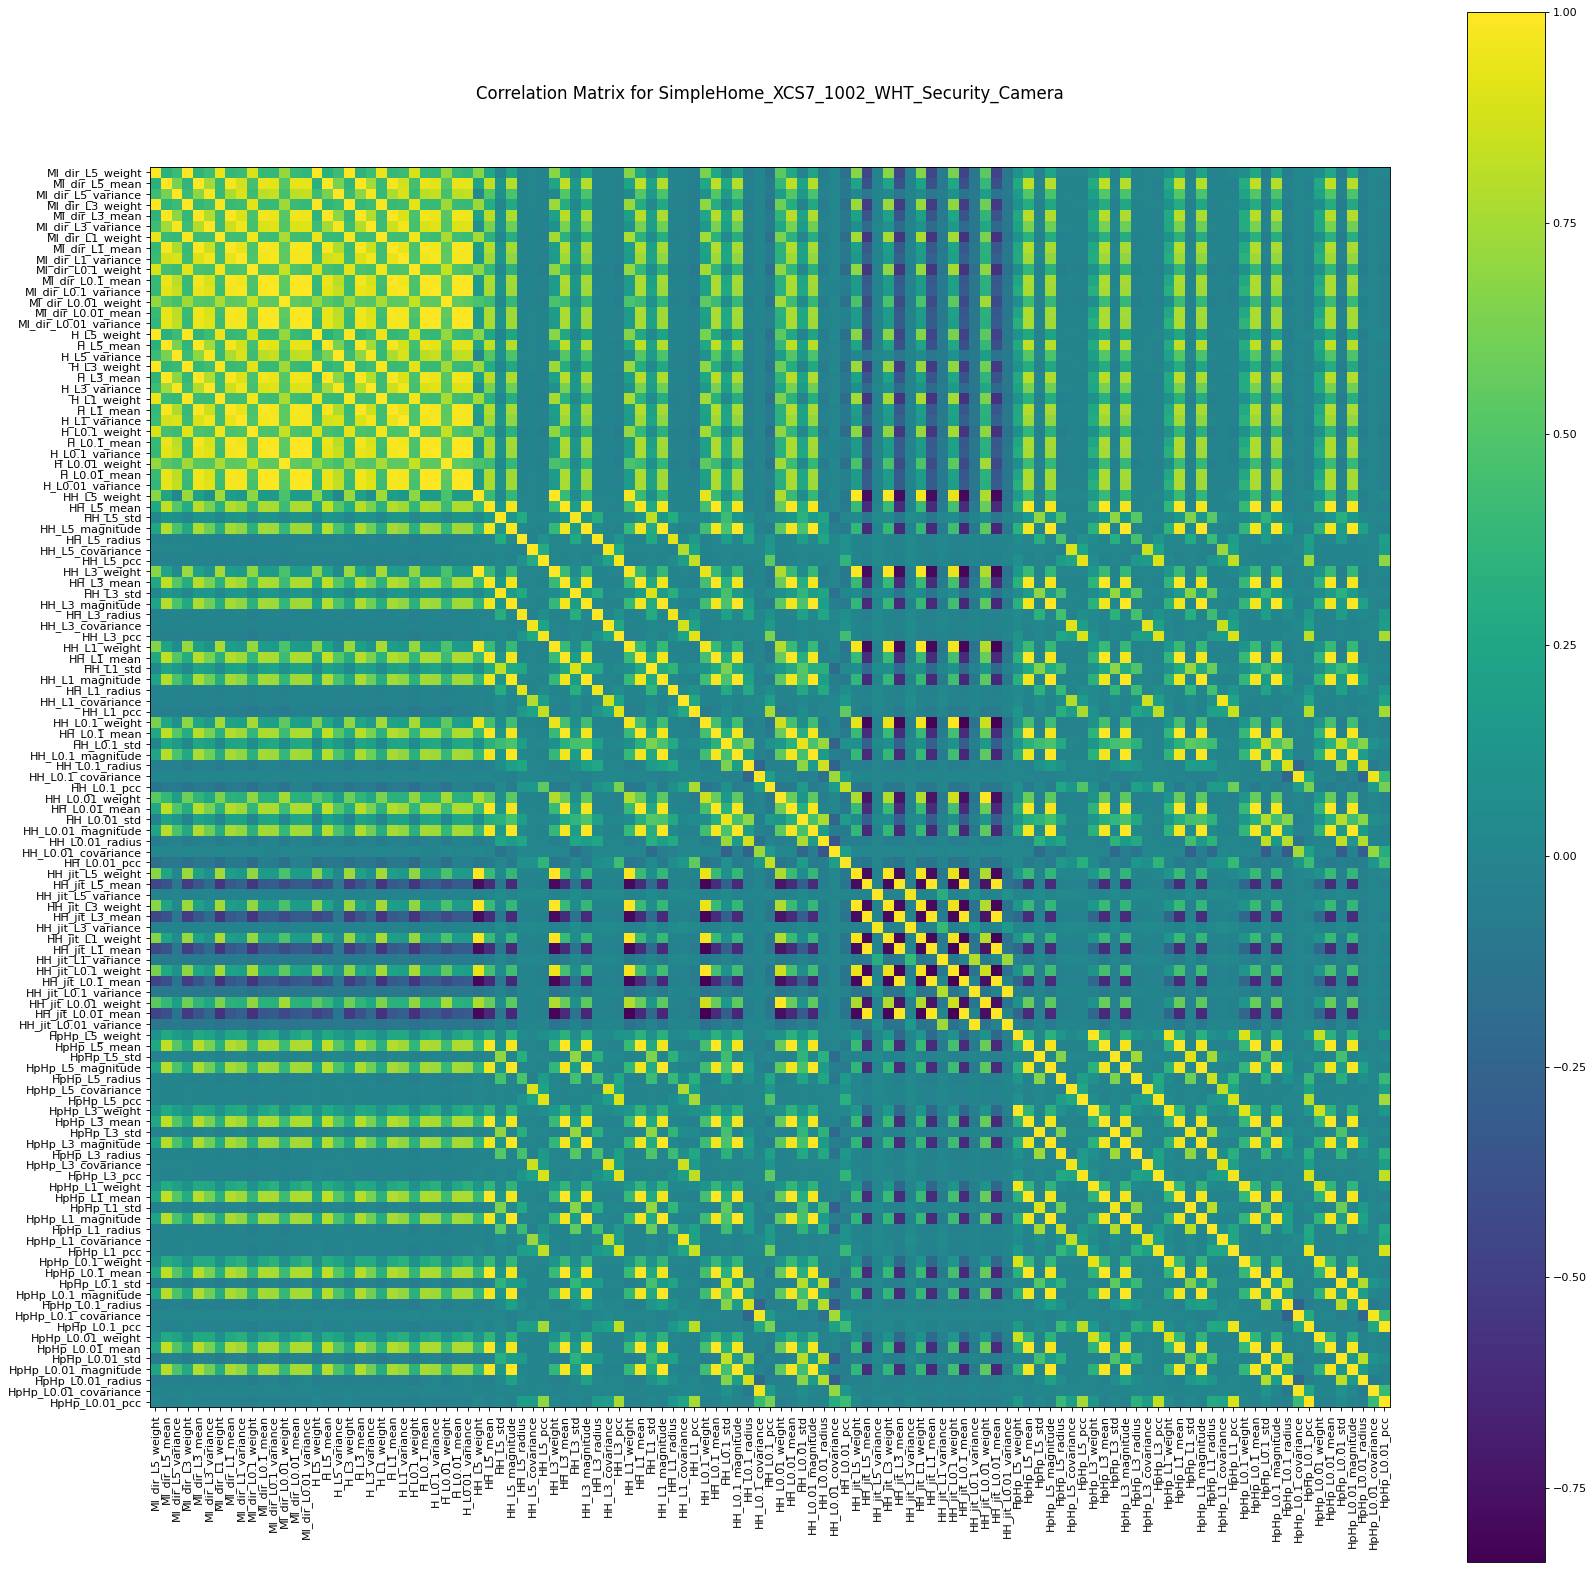

processing 9.benign.csv rows = 19528
processing 9.gafgyt.combo.csv rows = 59398
processing 9.gafgyt.junk.csv rows = 27413
processing 9.gafgyt.scan.csv rows = 28572
processing 9.gafgyt.tcp.csv rows = 98075
processing 9.gafgyt.udp.csv rows = 102980
processing 9.mirai.ack.csv rows = 107187
processing 9.mirai.scan.csv rows = 43674
processing 9.mirai.syn.csv rows = 122479
processing 9.mirai.udp.csv rows = 157084
processing 9.mirai.udpplain.csv rows = 84436
There are 850826 rows and 115 columns


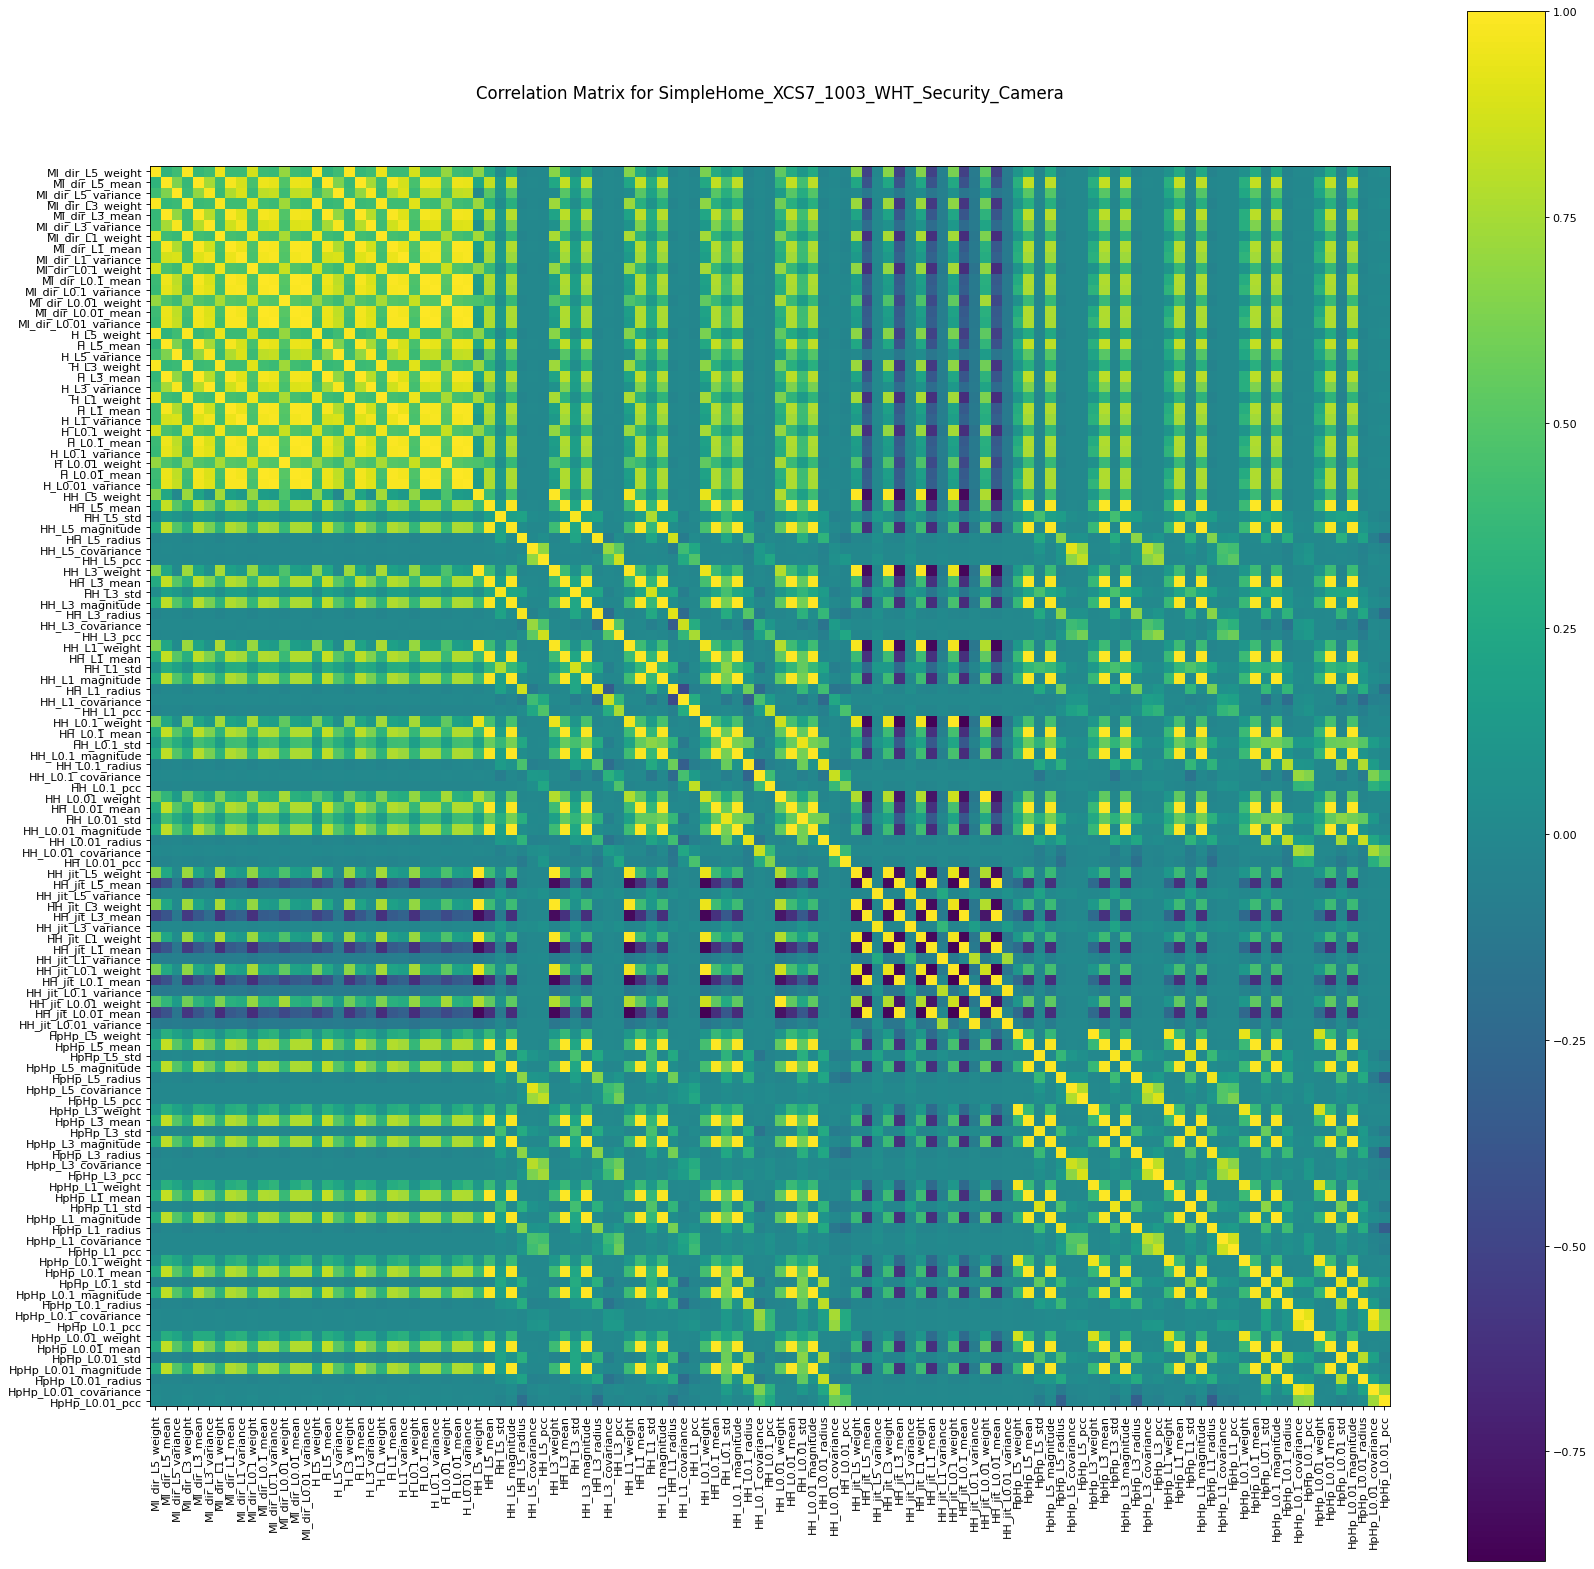

In [ ]:
for i in range(9):
    device_index = i
    device_id = device_index + 1
    device_name = dn_nbaiot[device_index]
    (X, y, Xdf) = get_nbaiot_device_data(device_id)
    nRow, nCol = Xdf.shape
    print(f'There are {nRow} rows and {nCol} columns')
    plot_correlation_matrix(Xdf, device_name)

Neural Network Structure Selection (Architecture Search)

In [ ]:
import multiprocessing

# Utility functions
# Print system information
def print_system_info():
    mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')  # e.g. 4015976448
    mem_gib = mem_bytes/(1024.**3)  # e.g. 3.74
    print("{:<23}{:f} GB".format('RAM:', mem_gib))
    print("{:<23}{:d}".format('CORES:', multiprocessing.cpu_count()))
    !lscpu

# Walk through input files
def print_input_files():
    # Input data files are available in the "../input/" directory.
    for dirname, _, filenames in os.walk('/content/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# Dump text files
def dump_text_file(fname):
    with open(fname, 'r') as f:
        print(f.read())


# Dump CSV files
def dump_csv_file(fname, count=5):
    # count: 0 - column names only, -1 - all rows, default = 5 rows max
    df = pd.read_csv(fname)
    if count < 0:
        count = df.shape[0]
    return df.head(count)

# Dataset related functions
ds_nbaiot = '/content/nbaiot-dataset'
dn_nbaiot = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

def fname(ds, f):
    if '.csv' not in f:
        f = f'{f}.csv'
    return os.path.join(ds, f)

def fname_nbaiot(f):
    return fname('/content/', f)

def get_nbaiot_device_files():
    nbaiot_all_files = dump_csv_file(fname_nbaiot('data_summary'), -1)
    nbaiot_all_files = nbaiot_all_files.iloc[:,0:1].values
    device_id = 1
    indices = []
    for j in range(len(nbaiot_all_files)):
        if str(device_id) not in str(nbaiot_all_files[j]):
            indices.append(j)
            device_id += 1
    nbaiot_device_files = np.split(nbaiot_all_files, indices)
    return nbaiot_device_files

def get_nbaiot_device_data(device_id, count_norm=-1, count_anom=-1):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    if count_anom == -1:
        count_anom = count_norm
    device_index = device_id -1
    device_files = get_nbaiot_device_files()
    device_file = device_files[device_index]
    df = pd.DataFrame()
    y = []
    for i in range(len(device_file)):
        fname = str(device_file[i][0])
        df_c = pd.read_csv(fname_nbaiot(fname))
        count = count_anom
        if 'benign' in fname:
            count = count_norm
        rows = count if count >=0 else df_c.shape[0]
        print("processing", fname, "rows =", rows)
        y_np = np.ones(rows) if 'benign' in fname else np.zeros(rows)
        y.extend(y_np.tolist())
        df = pd.concat([df.iloc[:,:].reset_index(drop=True),
                      df_c.iloc[:rows,:].reset_index(drop=True)], axis=0)
    X = df.iloc[:,:].values
    y = np.array(y)
    Xdf = df
    return (X, y, Xdf)

def get_nbaiot_devices_data():
    devices_data = []
    for i in range(9):
        device_id = i + 1
        (X, y) = get_nbaiot_device_data(device_id)
        devices_data.append((X, y))
    return devices_data

print_system_info()

RAM:                   12.715881 GB
CORES:                 2
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx

In [ ]:
def select_network_structure(method, layer_count_min, layer_count_max, node_count_min, node_count_max, samples_count, output_neuron_count):
    structure = []
    if method == 'random':
        layer_count = random.randint(layer_count_min, layer_count_max)
        for i in range(layer_count):
            node_count = random.randint(node_count_min, node_count_max)
            structure.append(node_count)
    if method == 'heuristics':
        N = samples_count
        m = output_neuron_count
        node_count_layer_1 = int(math.sqrt((m + 2) * N) + 2 * math.sqrt(N / (m + 2)))
        node_count_layer_2 = int(m * math.sqrt(N / (m + 2)))
        structure.append(node_count_layer_1)
        structure.append(node_count_layer_2)

    if method == 'genetic':
        l = 10
        chromosome = ''
        for i in range(l):
            x = random.randint(0, 1)
            chromosome += '{}'.format(x)
        chromosome_left = chromosome[0:6]
        chromosome_right = chromosome[6:]
        print('chromosome: {}'.format(chromosome))
        print('split: {} {}'.format(chromosome_left, chromosome_right))
        print('chromosome_left: {}'.format(chromosome_left))
        print('chromosome_right: {}'.format(chromosome_right))
        node_count_layer_1 = int(chromosome_left, 2) + random.randint(1, 10)
        node_count_layer_2 = int(chromosome_right, 2) + random.randint(1, 10)
        structure.append(node_count_layer_1)
        structure.append(node_count_layer_2)
    return structure

Random

In [ ]:
import random
import math

print(select_network_structure('random', 5, 10, 10, 20, 100, 2))

[18, 19, 10, 17, 17, 10, 17, 10, 20, 13]


Heuristics

In [ ]:
print(select_network_structure('heuristics', 5, 10, 10, 20, 100, 2))

[30, 10]


Genetic

In [ ]:
print(select_network_structure('genetic', 5, 10, 10, 20, 100, 2))

chromosome: 0000011010
split: 000001 1010
chromosome_left: 000001
chromosome_right: 1010
[8, 14]


## Self Organising Maps

In [ ]:
from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn


"""
    Minimalistic implementation of the Self Organizing Maps (SOM).
"""


def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.
    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))


class MiniSom(object):
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5, decay_function=None, random_seed=None):
        """
            Initializes a Self Organizing Maps.
            x,y - dimensions of the SOM
            input_len - number of the elements of the vectors in input
            sigma - spread of the neighborhood function (Gaussian), needs to be adequate to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T) where T is #num_iteration/2)
            learning_rate - initial learning rate
            (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
            decay_function, function that reduces learning_rate and sigma at each iteration
                            default function: lambda x,current_iteration,max_iter: x/(1+current_iteration/max_iter)
            random_seed, random seed to use.
        """
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self.random_generator = random.RandomState(random_seed)
        else:
            self.random_generator = random.RandomState(random_seed)
        if decay_function:
            self._decay_function = decay_function
        else:
            self._decay_function = lambda x, t, max_iter: x/(1+t/max_iter)
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        for i in range(x):
            for j in range(y):
                self.weights[i,j] = self.weights[i,j] / fast_norm(self.weights[i,j]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian

    def _activate(self, x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x, self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index])  # || x - w ||
            it.iternext()

    def activate(self, x):
        """ Returns the activation map to x """
        self._activate(x)
        return self.activation_map

    def gaussian(self, c, sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0], 2)/d)
        ay = exp(-power(self.neigy-c[1], 2)/d)
        return outer(ax, ay)  # the external product gives a matrix

    def diff_gaussian(self, c, sigma):
        """ Mexican hat centered in c (unused) """
        xx, yy = meshgrid(self.neigx, self.neigy)
        p = power(xx-c[0], 2) + power(yy-c[1], 2)
        d = 2*pi*sigma*sigma
        return exp(-p/d)*(1-2/d*p)

    def winner(self, x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(), self.activation_map.shape)

    def update(self, x, win, t):
        """
            Updates the weights of the neurons.
            x - current pattern to learn
            win - position of the winning neuron for x (array or tuple).
            t - iteration index
        """
        eta = self._decay_function(self.learning_rate, t, self.T)
        sig = self._decay_function(self.sigma, t, self.T) # sigma and learning rate decrease with the same rule
        g = self.neighborhood(win, sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])
            # normalization
            self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def quantization(self, data):
        """ Assigns a code book (weights vector of the winning neuron) to each sample in data. """
        q = zeros(data.shape)
        for i, x in enumerate(data):
            q[i] = self.weights[self.winner(x)]
        return q

    def random_weights_init(self, data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[self.random_generator.randint(len(data))]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()

    def train_random(self, data, num_iteration):
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)
        for iteration in range(num_iteration):
            rand_i = self.random_generator.randint(len(data)) # pick a random sample
            self.update(data[rand_i], self.winner(data[rand_i]), iteration)

    def train_batch(self, data, num_iteration):
        """ Trains using all the vectors in data sequentially """
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx], self.winner(data[idx]), iteration)
            iteration += 1

    def _init_T(self, num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2  # keeps the learning rate nearly constant for the last half of the iterations

    def distance_map(self):
        """ Returns the distance map of the weights.
            Each cell is the normalised sum of the distances between a neuron and its neighbours.
        """
        um = zeros((self.weights.shape[0], self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii, jj, :]-self.weights[it.multi_index])
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self, data):
        """
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self.weights.shape[0], self.weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self, data):
        """
            Returns the quantization error computed as the average distance between
            each input sample and its best matching unit.
        """
        error = 0
        for x in data:
            error += fast_norm(x-self.weights[self.winner(x)])
        return error/len(data)

    def win_map(self, data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap

### unit tests
from numpy.testing import assert_almost_equal, assert_array_almost_equal, assert_array_equal


class TestMinisom:
    def setup_method(self, method):
        self.som = MiniSom(5, 5, 1)
        for i in range(5):
            for j in range(5):
                assert_almost_equal(1.0, linalg.norm(self.som.weights[i,j]))  # checking weights normalization
        self.som.weights = zeros((5, 5))  # fake weights
        self.som.weights[2, 3] = 5.0
        self.som.weights[1, 1] = 2.0

    def test_decay_function(self):
        assert self.som._decay_function(1., 2., 3.) == 1./(1.+2./3.)

    def test_fast_norm(self):
        assert fast_norm(array([1, 3])) == sqrt(1+9)

    def test_gaussian(self):
        bell = self.som.gaussian((2, 2), 1)
        assert bell.max() == 1.0
        assert bell.argmax() == 12  # unravel(12) = (2,2)

    def test_win_map(self):
        winners = self.som.win_map([5.0, 2.0])
        assert winners[(2, 3)][0] == 5.0
        assert winners[(1, 1)][0] == 2.0

    def test_activation_reponse(self):
        response = self.som.activation_response([5.0, 2.0])
        assert response[2, 3] == 1
        assert response[1, 1] == 1

    def test_activate(self):
        assert self.som.activate(5.0).argmin() == 13.0  # unravel(13) = (2,3)

    def test_quantization_error(self):
        self.som.quantization_error([5, 2]) == 0.0
        self.som.quantization_error([4, 1]) == 0.5

    def test_quantization(self):
        q = self.som.quantization(array([4, 2]))
        assert q[0] == 5.0
        assert q[1] == 2.0

    def test_random_seed(self):
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        assert_array_almost_equal(som1.weights, som2.weights)  # same initialization
        data = random.rand(100,2)
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som1.train_random(data,10)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2.train_random(data,10)
        assert_array_almost_equal(som1.weights,som2.weights)  # same state after training

    def test_train_batch(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_batch(data, 10)
        assert q1 > som.quantization_error(data)

    def test_train_random(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_random(data, 10)
        assert q1 > som.quantization_error(data)

    def test_random_weights_init(self):
        som = MiniSom(2, 2, 2, random_seed=1)
        som.random_weights_init(array([[1.0, .0]]))
        for w in som.weights:
            assert_array_equal(w[0], array([1.0, .0]))

In [ ]:
class Som:
    def __init__(self, x=20, y=None):
        '''
            parameter: x, y, size of the grid,
                     default: 20x20, if y is not supplied, y is the same as x
        '''
        self.som = None
        self.map_x = x
        if not y:
            self.map_y = x # square grid
        else:
            self.map_y = y

    def fit(self, X):
        '''
            Fit SOM to the input data.
            Parameters: X = a numpy array and it should contain
                            all columns as features and any manually
                            labeled columns should be removed before
                            calling this function.
        '''
        nb_features = X.shape[1] # number of features
        som = MiniSom(x = self.map_x, y = self.map_y, input_len = nb_features, sigma = 1.0, learning_rate = 0.5)
        som.random_weights_init(X)
        som.train_random(data = X, num_iteration = 2000)
        dm = som.distance_map()
        mid = []
        for x in X:
            w = som.winner(x)
            (x,y) = w
            mid.append(dm[x][y])

        self.dm = dm
        self.som = som
        self.grid = (self.map_x, self.map_y)
        self.mid = mid

    def predict(self, threshold = 0.02, anomaly_label=0):
        '''Predict data as normal or anomalous based upon mean inter-neuron distance.
             Need to call fit() before calling this.
             Parameters: threshold = the threshold (default = 0.02) that is used to
                                     determine if normal = 1 (when mid <= threshold),
                                     or anomalous = 0 otherwise.
                         anomaly_label = the value to label anomalies, default = 0'''
        if self.som is None:
            raise Exception('Call fit() before calling this')

        y_pred = []
        for m in self.mid:
            normal = (1 if m <= threshold else anomaly_label)
            y_pred.append(normal)
        return y_pred

    def plot_marker(self, xy, m, c):
        plot(xy[0] + 0.5,
             xy[1] + 0.5,
             m,
             markeredgecolor = c,
             markerfacecolor = 'None',
             markersize = 10,
             markeredgewidth = 2)

    def plot_distance_map_labels(self, t, X, Y):
        '''Plots distance map with labels. Need to call fit() before calling this.
             Parameters: X = input features
                         Y = labels, 1 = normal, 0 = anomalous.'''
        if self.som is None:
            raise Exception('Call fit() before calling this')

        red_set = set() # normal instances
        green_set = set() # anomalous instances
        for i, x in enumerate(X):
            w = self.som.winner(x)
            if int(Y[i]) == 0:
                red_set.add(w)
            else:
                green_set.add(w)
        bone()
        pcolor(self.dm.T)
        colorbar()
        (map_x, map_y) = self.grid
        for x in range(map_x):
            for y in range(map_y):
                xy = (x,y)
                if (xy in red_set) and (xy in green_set):
                    self.plot_marker(xy, 'h', 'y')
                elif xy in red_set:
                    self.plot_marker(xy, 'o', 'r')
                elif xy in green_set:
                    self.plot_marker(xy, 's', 'g')
                else:
                    pass
        title(t)
        show()

In [ ]:
# Imports
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

from keras.layers import Input, Dense
from keras import regularizers, Model
from keras.models import Sequential

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc
from sklearn.datasets import make_blobs

from imageio import imwrite
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from PIL import Image, ImageChops

In [ ]:
# Walk through input files
def print_input_files():
    for dirname, _, filenames in os.walk('/content/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# Dump text files
def dump_text_file(fname):
    with open(fname, 'r') as f:
        print(f.read())

# Dump CSV files
def dump_csv_file(fname, count=5):
    # count: 0 - column names only, -1 - all rows, default = 5 rows max
    df = pd.read_csv(fname)
    if count < 0:
        count = df.shape[0]
    return df.head(count)

# Dataset related functions
ds_nbaiot = '/content/nbaiot-dataset'
dn_nbaiot = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

def fname(ds, f):
    if '.csv' not in f:
        f = f'{f}.csv'
    return os.path.join(ds, f)

def fname_nbaiot(f):
    return fname('/content/', f)

def get_nbaiot_device_files():
    nbaiot_all_files = dump_csv_file(fname_nbaiot('data_summary'), -1)
    nbaiot_all_files = nbaiot_all_files.iloc[:,0:1].values
    device_id = 1
    indices = []
    for j in range(len(nbaiot_all_files)):
        if str(device_id) not in str(nbaiot_all_files[j]):
            indices.append(j)
            device_id += 1
    nbaiot_device_files = np.split(nbaiot_all_files, indices)
    return nbaiot_device_files

def get_nbaiot_device_data(device_id, count_norm=-1, count_anom=-1):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    if count_anom == -1:
        count_anom = count_norm
    device_index = device_id -1
    device_files = get_nbaiot_device_files()
    device_file = device_files[device_index]
    df = pd.DataFrame()
    y = []
    for i in range(len(device_file)):
        fname = str(device_file[i][0])
        df_c = pd.read_csv(fname_nbaiot(fname))
        count = count_anom
        if 'benign' in fname:
            count = count_norm
        rows = count if count >=0 else df_c.shape[0]
        print("processing", fname, "rows =", rows)
        y_np = np.ones(rows) if 'benign' in fname else np.zeros(rows)
        y.extend(y_np.tolist())
        df = pd.concat([df.iloc[:,:].reset_index(drop=True),
                      df_c.iloc[:rows,:].reset_index(drop=True)], axis=0)
    X = df.iloc[:,:].values
    y = np.array(y)
    return (X, y)

def get_nbaiot_devices_data():
    devices_data = []
    for i in range(9):
        device_id = i + 1
        (X, y) = get_nbaiot_device_data(device_id)
        devices_data.append((X, y))
    return devices_data
#print_input_files()

processing 1.benign.csv rows = 49548
processing 1.gafgyt.combo.csv rows = 59718
processing 1.gafgyt.junk.csv rows = 29068
processing 1.gafgyt.scan.csv rows = 29849
processing 1.gafgyt.tcp.csv rows = 92141
processing 1.gafgyt.udp.csv rows = 105874
processing 1.mirai.ack.csv rows = 102195
processing 1.mirai.scan.csv rows = 107685
processing 1.mirai.syn.csv rows = 122573
processing 1.mirai.udp.csv rows = 237665
processing 1.mirai.udpplain.csv rows = 81982
X.shape (1018298, 115) y.shape (1018298,)


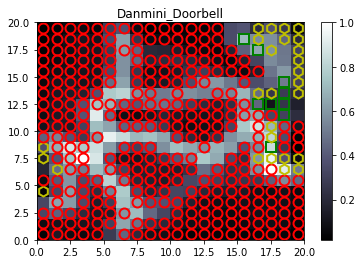

Danmini_Doorbell
Threshold, Accurary, TN, FP, FN, TP
0.00,0.95,968750,0,49548,0
0.01,0.95,968750,0,49548,0
0.02,0.95,963855,4895,49548,0
0.03,0.94,954733,14017,49548,0
0.04,0.92,938238,30512,49501,47
0.05,0.85,869751,98999,49501,47
0.06,0.82,834123,134627,49501,47
0.07,0.78,796428,172322,49501,47
0.08,0.75,760047,208703,48785,763
0.09,0.68,693433,275317,48785,763
0.10,0.63,640553,328197,48785,763
0.11,0.61,619111,349639,48777,771
0.12,0.57,580183,388567,48777,771
0.13,0.54,550965,417785,48777,771
0.14,0.53,534053,434697,48777,771
0.15,0.52,525570,443180,48715,833
0.16,0.50,511111,457639,48715,833
0.17,0.47,479323,489427,48715,833
0.18,0.45,457464,511286,48715,833
0.19,0.45,453901,514849,48715,833
0.20,0.44,448227,520523,48715,833
0.21,0.43,431490,537260,47900,1648
0.22,0.42,420221,548529,43984,5564
0.23,0.42,417116,551634,43984,5564
0.24,0.41,413502,555248,43984,5564
0.25,0.40,403843,564907,43984,5564
0.26,0.42,393965,574785,13868,35680
0.27,0.41,383811,584939,13786,35762
0.28,0.41,380

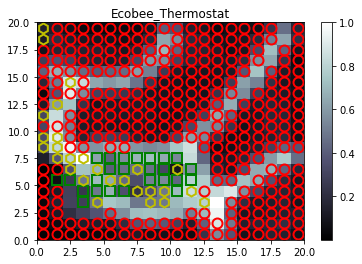

Ecobee_Thermostat
Threshold, Accurary, TN, FP, FN, TP
0.00,0.98,822763,0,13113,0
0.01,0.75,630487,192276,13113,0
0.02,0.75,626122,196641,13113,0
0.03,0.74,614392,208371,13113,0
0.04,0.73,606527,216236,13113,0
0.05,0.70,586355,236408,13113,0
0.06,0.69,578918,243845,13113,0
0.07,0.68,565665,257098,13108,5
0.08,0.64,538654,284109,13108,5
0.09,0.60,503235,319528,13108,5
0.10,0.57,474371,348392,13108,5
0.11,0.53,444043,378720,12771,342
0.12,0.48,404526,418237,12770,343
0.13,0.42,354596,468167,12770,343
0.14,0.38,317377,505386,12770,343
0.15,0.36,299113,523650,12763,350
0.16,0.35,291614,531149,12763,350
0.17,0.31,259193,563570,12763,350
0.18,0.28,234595,588168,12763,350
0.19,0.27,226053,596710,12763,350
0.20,0.27,222401,600362,12763,350
0.21,0.25,209447,613316,12763,350
0.22,0.25,207060,615703,12763,350
0.23,0.24,202827,619936,12760,353
0.24,0.23,193603,629160,12760,353
0.25,0.23,188724,634039,11120,1993
0.26,0.22,183693,639070,11120,1993
0.27,0.21,177006,645757,11120,1993
0.28,0.21,174686,6

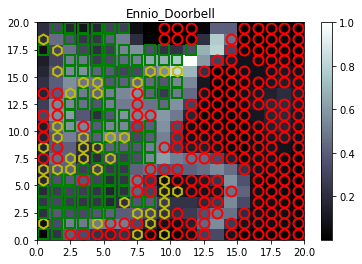

Ennio_Doorbell
Threshold, Accurary, TN, FP, FN, TP
0.00,0.89,316400,0,39100,0
0.01,0.59,208456,107944,39100,0
0.02,0.31,110128,206272,39087,13
0.03,0.29,101949,214451,39087,13
0.04,0.24,86579,229821,39087,13
0.05,0.21,74335,242065,39087,13
0.06,0.18,64717,251683,39078,22
0.07,0.16,56395,260005,38487,613
0.08,0.14,47159,269241,38212,888
0.09,0.12,43135,273265,38212,888
0.10,0.11,36863,279537,37596,1504
0.11,0.10,34936,281464,37596,1504
0.12,0.09,32200,284200,37596,1504
0.13,0.09,30715,285685,37575,1525
0.14,0.08,27319,289081,37575,1525
0.15,0.08,25987,290413,37575,1525
0.16,0.07,23566,292834,37238,1862
0.17,0.06,21053,295347,37237,1863
0.18,0.07,18656,297744,32728,6372
0.19,0.07,17799,298601,32481,6619
0.20,0.08,17781,298619,27198,11902
0.21,0.08,17422,298978,27021,12079
0.22,0.09,15996,300404,24464,14636
0.23,0.08,14588,301812,24460,14640
0.24,0.08,13649,302751,22621,16479
0.25,0.09,12994,303406,21042,18058
0.26,0.08,11823,304577,20790,18310
0.27,0.08,11215,305185,20711,18389
0.28,0.08

In [ ]:
for i in range(9):
    device_index = i
    device_id = i + 1
    device_name = dn_nbaiot[device_index]
    (X, y) = get_nbaiot_device_data(device_id)
    print('X.shape', X.shape, 'y.shape', y.shape)
    X_std = StandardScaler().fit_transform(X)
    som = Som()
    som.fit(X_std)
    som.plot_distance_map_labels(device_name, X_std, y)
    step = 0.01
    threshold = 0.0
    i = 1
    print(device_name)
    print("Threshold, Accurary, TN, FP, FN, TP")
    while threshold <= 1:
        y_pred = som.predict(threshold)
        tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
        acc = accuracy_score(y, y_pred)
        print(f'{threshold:.2f},{acc:.2f},{tn},{fp},{fn},{tp}')
        threshold += step
        i += 1

## Model Training

In [ ]:
benign=pd.read_csv('/content/6.benign.csv')
g_c=pd.read_csv('/content/5.gafgyt.combo.csv')
g_j=pd.read_csv('/content/5.gafgyt.junk.csv')
g_s=pd.read_csv('/content/5.gafgyt.scan.csv')
g_t=pd.read_csv('/content/5.gafgyt.tcp.csv')
g_u=pd.read_csv('/content/5.gafgyt.udp.csv')
m_a=pd.read_csv('/content/5.mirai.ack.csv')
m_sc=pd.read_csv('/content/5.mirai.scan.csv')
m_sy=pd.read_csv('/content/5.mirai.syn.csv')
m_u=pd.read_csv('/content/5.mirai.udp.csv')
m_u_p=pd.read_csv('/content/5.mirai.udpplain.csv')

benign=benign.sample(frac=0.25,replace=False)
g_c=g_c.sample(frac=0.25,replace=False)
g_j=g_j.sample(frac=0.5,replace=False)
g_s=g_s.sample(frac=0.5,replace=False)
g_t=g_t.sample(frac=0.15,replace=False)
g_u=g_u.sample(frac=0.15,replace=False)
m_a=m_a.sample(frac=0.25,replace=False)
m_sc=m_sc.sample(frac=0.15,replace=False)
m_sy=m_sy.sample(frac=0.25,replace=False)
m_u=m_u.sample(frac=0.1,replace=False)
m_u_p=m_u_p.sample(frac=0.27,replace=False)

benign['type']='benign'
m_u['type']='mirai_udp'
g_c['type']='gafgyt_combo'
g_j['type']='gafgyt_junk'
g_s['type']='gafgyt_scan'
g_t['type']='gafgyt_tcp'
g_u['type']='gafgyt_udp'
m_a['type']='mirai_ack'
m_sc['type']='mirai_scan'
m_sy['type']='mirai_syn'
m_u_p['type']='mirai_udpplain'

data=pd.concat([benign,m_u,g_c,g_j,g_s,g_t,g_u,m_a,m_sc,m_sy,m_u_p],
               axis=0, sort=False, ignore_index=True)

In [ ]:
#Listing the instances of each class
data.groupby('type')['type'].count()

type
benign            24628
gafgyt_combo      15345
gafgyt_junk       15449
gafgyt_scan       14648
gafgyt_tcp        15676
gafgyt_udp        15602
mirai_ack         15138
mirai_scan        14517
mirai_syn         16436
mirai_udp         15625
mirai_udpplain    15304
Name: type, dtype: int64

In [ ]:
#shuffle rows of dataframe 
sampler=np.random.permutation(len(data))
data=data.take(sampler)
data.head()

MI_dir_L5_weight  MI_dir_L5_mean  ...  HpHp_L0.01_pcc        type
36576          63.372734      248.119080  ...             0.0   mirai_udp
143534         19.490291       60.064238  ...             0.0  mirai_scan
115430          1.000000       60.000000  ...             0.0  gafgyt_udp
143037         89.776098       60.000020  ...             0.0  mirai_scan
126139         68.721841       60.000001  ...             0.0   mirai_ack

[5 rows x 116 columns]

In [ ]:
#dummy encode labels, store separately
labels_full=pd.get_dummies(data['type'], prefix='type')
labels_full.head()

type_benign  type_gafgyt_combo  ...  type_mirai_udp  type_mirai_udpplain
36576             0                  0  ...               1                    0
143534            0                  0  ...               0                    0
115430            0                  0  ...               0                    0
143037            0                  0  ...               0                    0
126139            0                  0  ...               0                    0

[5 rows x 11 columns]

In [ ]:
#drop labels from training dataset
data=data.drop(columns='type')
data.head()

MI_dir_L5_weight  MI_dir_L5_mean  ...  HpHp_L0.01_covariance  HpHp_L0.01_pcc
36576          63.372734      248.119080  ...                    0.0             0.0
143534         19.490291       60.064238  ...                    0.0             0.0
115430          1.000000       60.000000  ...                    0.0             0.0
143037         89.776098       60.000020  ...                    0.0             0.0
126139         68.721841       60.000001  ...                    0.0             0.0

[5 rows x 115 columns]

In [ ]:
#standardize numerical columns
def standardize(df,col):
    df[col]= (df[col]-df[col].mean())/df[col].std()

data_st=data.copy()
for i in (data_st.iloc[:,:-1].columns):
    standardize (data_st,i)

data_st.head()

MI_dir_L5_weight  MI_dir_L5_mean  ...  HpHp_L0.01_covariance  HpHp_L0.01_pcc
36576          -0.131397        0.861351  ...              -0.132377             0.0
143534         -0.808782       -0.615320  ...              -0.132377             0.0
115430         -1.094205       -0.615825  ...              -0.132377             0.0
143037          0.276175       -0.615824  ...              -0.132377             0.0
126139         -0.048826       -0.615825  ...              -0.132377             0.0

[5 rows x 115 columns]

In [ ]:
#training data for the neural net
train_data_st=data_st.values
train_data_st

array([[-0.131397  ,  0.86135075,  1.83939847, ..., -0.13248803,
        -0.13237741,  0.        ],
       [-0.80878201, -0.61532009, -0.60103499, ..., -0.13248803,
        -0.13237741,  0.        ],
       [-1.09420474, -0.61582451, -0.60107654, ..., -0.13248803,
        -0.13237741,  0.        ],
       ...,
       [ 1.40556306,  0.85772006,  1.83700384, ..., -0.13248803,
        -0.13237741,  0.        ],
       [-1.09420474, -0.61582451, -0.60107654, ..., -0.13248803,
        -0.13237741,  0.        ],
       [-1.09318355, -0.50593206, -0.60107633, ..., -0.13248803,
        -0.13237741,  0.        ]])

In [ ]:
#labels for training
labels=labels_full.values
labels

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Keras model

AE Model 1

In [ ]:
#import libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping


# test/train split  25% test
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(
    train_data_st, labels, test_size=0.25, random_state=42)

#  create and fit model
model = Sequential()
model.add(Dense(10, input_dim=train_data_st.shape[1], activation='relu'))
model.add(Dense(40, input_dim=train_data_st.shape[1], activation='relu'))
model.add(Dense(10, input_dim=train_data_st.shape[1], activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(labels.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto')
model.fit(x_train_st,y_train_st,validation_data=(x_test_st,y_test_st),
          callbacks=[monitor],verbose=2,epochs=500)

Epoch 1/500
4181/4181 - 6s - loss: 1.1724 - val_loss: 0.8781
Epoch 2/500
4181/4181 - 5s - loss: 0.7466 - val_loss: 0.6525
Epoch 3/500
4181/4181 - 5s - loss: 0.6115 - val_loss: 0.5706
Epoch 4/500
4181/4181 - 5s - loss: 0.5372 - val_loss: 0.4983
Epoch 5/500
4181/4181 - 5s - loss: 0.4873 - val_loss: 0.4821
Epoch 6/500
4181/4181 - 5s - loss: 0.4481 - val_loss: 0.4250
Epoch 7/500
4181/4181 - 5s - loss: 0.4199 - val_loss: 0.3895
Epoch 8/500
4181/4181 - 5s - loss: 0.3915 - val_loss: 0.3633
Epoch 9/500
4181/4181 - 5s - loss: 0.3724 - val_loss: 0.4218
Epoch 10/500
4181/4181 - 5s - loss: 0.3591 - val_loss: 0.3618
Epoch 11/500
4181/4181 - 5s - loss: 0.3438 - val_loss: 0.3306
Epoch 12/500
4181/4181 - 5s - loss: 0.3361 - val_loss: 0.3234
Epoch 13/500
4181/4181 - 5s - loss: 0.3326 - val_loss: 0.3400
Epoch 14/500
4181/4181 - 5s - loss: 0.3200 - val_loss: 0.3345
Epoch 15/500
4181/4181 - 5s - loss: 0.3151 - val_loss: 0.3025
Epoch 16/500
4181/4181 - 5s - loss: 0.3072 - val_loss: 0.3087
Epoch 17/500
4181

In [ ]:
# metrics
pred_st = model.predict(x_test_st)
pred_st = np.argmax(pred_st,axis=1)
y_eval_st = np.argmax(y_test_st,axis=1)
score_st = metrics.accuracy_score(y_eval_st, pred_st)
print("accuracy: {}".format(score_st))

accuracy: 0.8552206673842842


AE Model 2

In [ ]:
#second model
model2 = Sequential()
model2.add(Dense(32, input_dim=train_data_st.shape[1], activation='relu'))
model2.add(Dense(72, input_dim=train_data_st.shape[1], activation='relu'))
model2.add(Dense(32, input_dim=train_data_st.shape[1], activation='relu'))
model2.add(Dense(1, kernel_initializer='normal'))
model2.add(Dense(labels.shape[1],activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto')
model2.fit(x_train_st,y_train_st,validation_data=(x_test_st,y_test_st),
          callbacks=[monitor],verbose=2,epochs=100)

Epoch 1/100
4181/4181 - 6s - loss: 1.1006 - val_loss: 0.7929
Epoch 2/100
4181/4181 - 5s - loss: 0.7128 - val_loss: 0.6214
Epoch 3/100
4181/4181 - 5s - loss: 0.6038 - val_loss: 0.5565
Epoch 4/100
4181/4181 - 5s - loss: 0.5041 - val_loss: 0.4449
Epoch 5/100
4181/4181 - 5s - loss: 0.4087 - val_loss: 0.3663
Epoch 6/100
4181/4181 - 5s - loss: 0.3515 - val_loss: 0.3305
Epoch 7/100
4181/4181 - 5s - loss: 0.3164 - val_loss: 0.3316
Epoch 8/100
4181/4181 - 5s - loss: 0.3049 - val_loss: 0.2947
Epoch 9/100
4181/4181 - 5s - loss: 0.2847 - val_loss: 0.2729
Epoch 10/100
4181/4181 - 5s - loss: 0.2662 - val_loss: 0.2692
Epoch 11/100
4181/4181 - 5s - loss: 0.2448 - val_loss: 0.2226
Epoch 12/100
4181/4181 - 5s - loss: 0.2276 - val_loss: 0.2294
Epoch 13/100
4181/4181 - 5s - loss: 0.2198 - val_loss: 0.2084
Epoch 14/100
4181/4181 - 7s - loss: 0.2024 - val_loss: 0.2053
Epoch 15/100
4181/4181 - 5s - loss: 0.2161 - val_loss: 0.2052
Epoch 16/100
4181/4181 - 5s - loss: 0.1950 - val_loss: 0.2287
Epoch 17/100
4181

In [ ]:
# metrics
pred_st = model2.predict(x_test_st)
pred_st_2 = np.argmax(pred_st,axis=1)
y_eval_st_2 = np.argmax(y_test_st,axis=1)
score_st_2 = metrics.accuracy_score(y_eval_st_2, pred_st_2)
print("accuracy: {}".format(score_st_2))

accuracy: 0.9092438105489774


## Classification Reports

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
#Model 1 (Example)
print(classification_report(y_eval_st, pred_st.argmax(-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6153
           1       0.99      0.99      0.99      3841
           2       0.99      0.98      0.99      3903
           3       1.00      1.00      1.00      3535
           4       0.00      0.00      0.00      3901
           5       0.50      1.00      0.66      3848
           6       1.00      1.00      1.00      3765
           7       1.00      1.00      1.00      3627
           8       1.00      1.00      1.00      4198
           9       1.00      1.00      1.00      3958
          10       1.00      1.00      1.00      3863

    accuracy                           0.91     44592
   macro avg       0.86      0.91      0.88     44592
weighted avg       0.87      0.91      0.88     44592



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Model 2 (Example)
print(classification_report(y_eval_st_2, pred_st_2))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6153
           1       0.99      0.99      0.99      3841
           2       0.99      0.98      0.99      3903
           3       1.00      1.00      1.00      3535
           4       0.00      0.00      0.00      3901
           5       0.50      1.00      0.66      3848
           6       1.00      1.00      1.00      3765
           7       1.00      1.00      1.00      3627
           8       1.00      1.00      1.00      4198
           9       1.00      1.00      1.00      3958
          10       1.00      1.00      1.00      3863

    accuracy                           0.91     44592
   macro avg       0.86      0.91      0.88     44592
weighted avg       0.87      0.91      0.88     44592

